## ALL VES (1D)

#### TRAVERSE 1

10/10/25 - 17:02:51 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:51 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


[INFO] Loaded rough models for 20 VES soundings from Pre Intrepreted depth and resistivity.xlsx


10/10/25 - 17:02:51 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:51 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:51 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:52 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:52 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:52 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:52 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


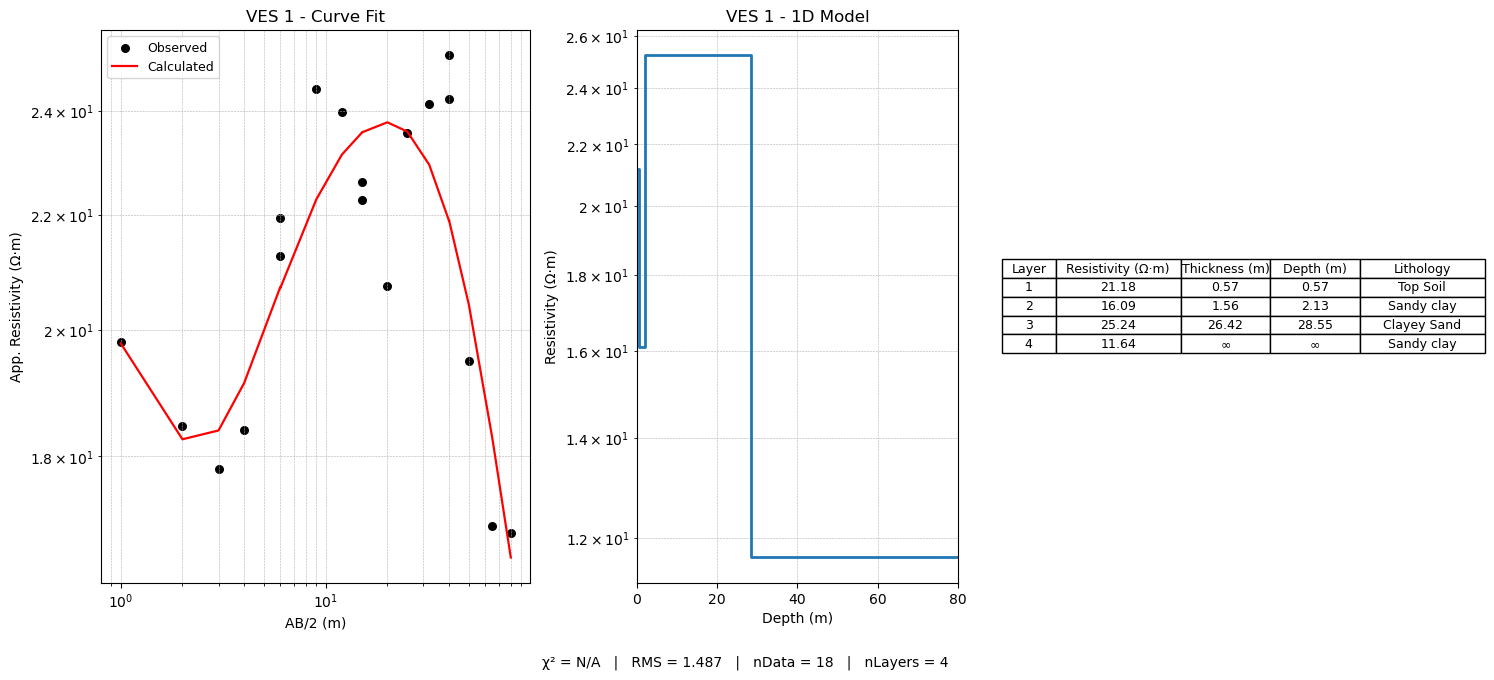

10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:54 - pyGIMLi - WARNING - Multiprocess 

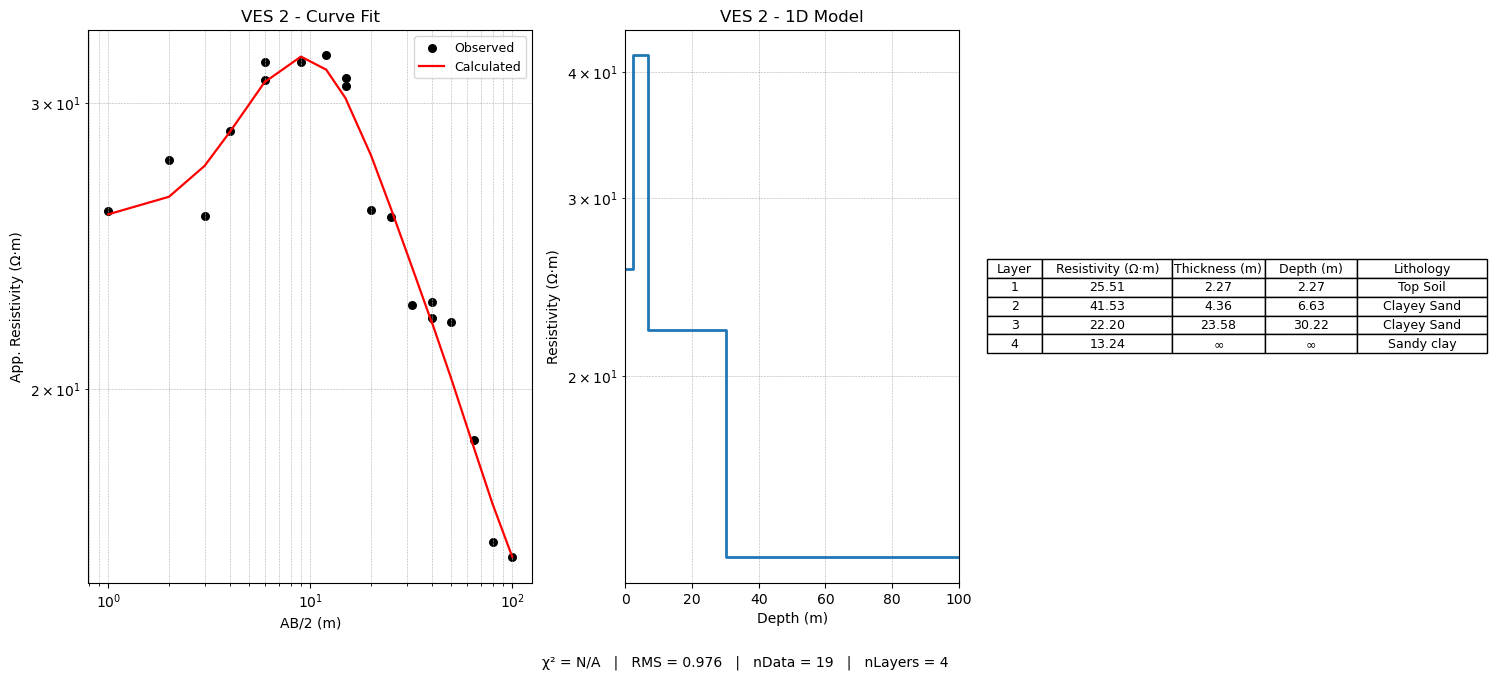

10/10/25 - 17:02:57 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:57 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:57 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:57 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:57 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


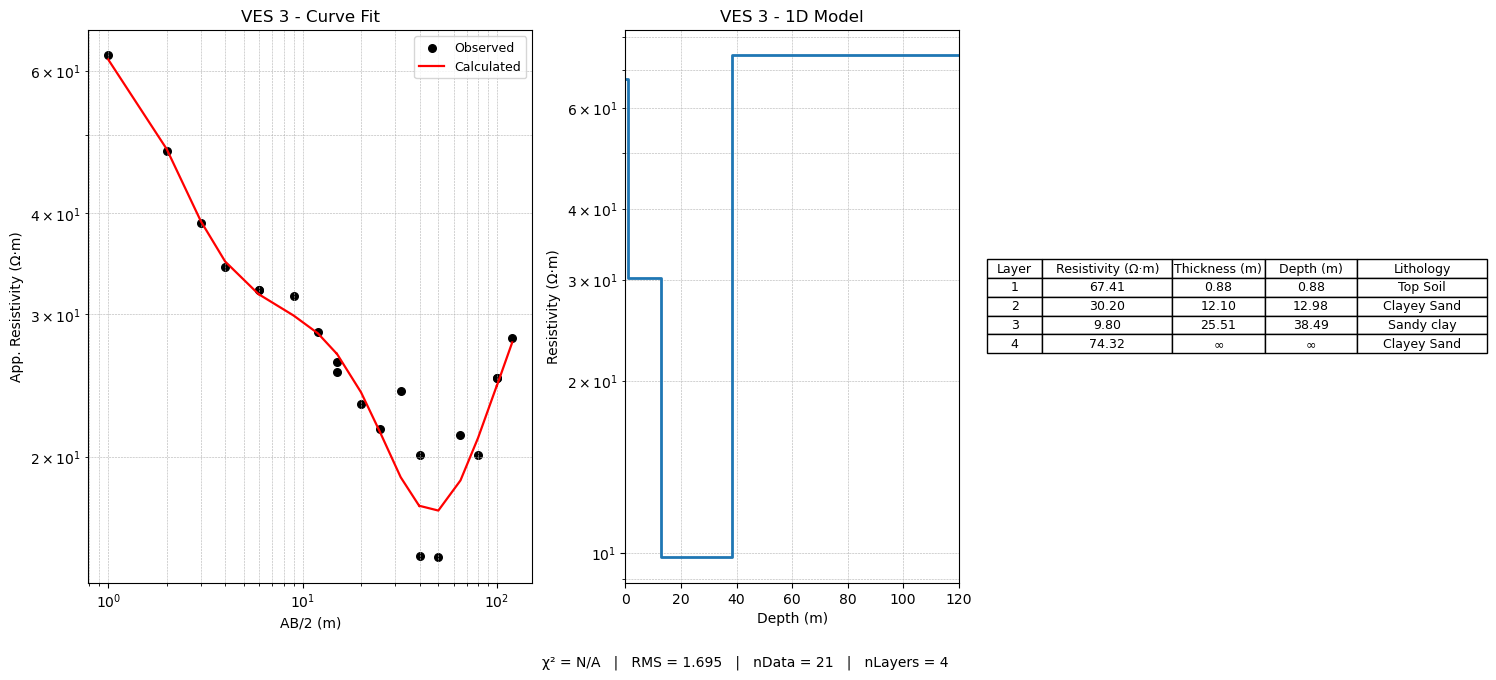

10/10/25 - 17:02:59 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:59 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 17:02:59 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


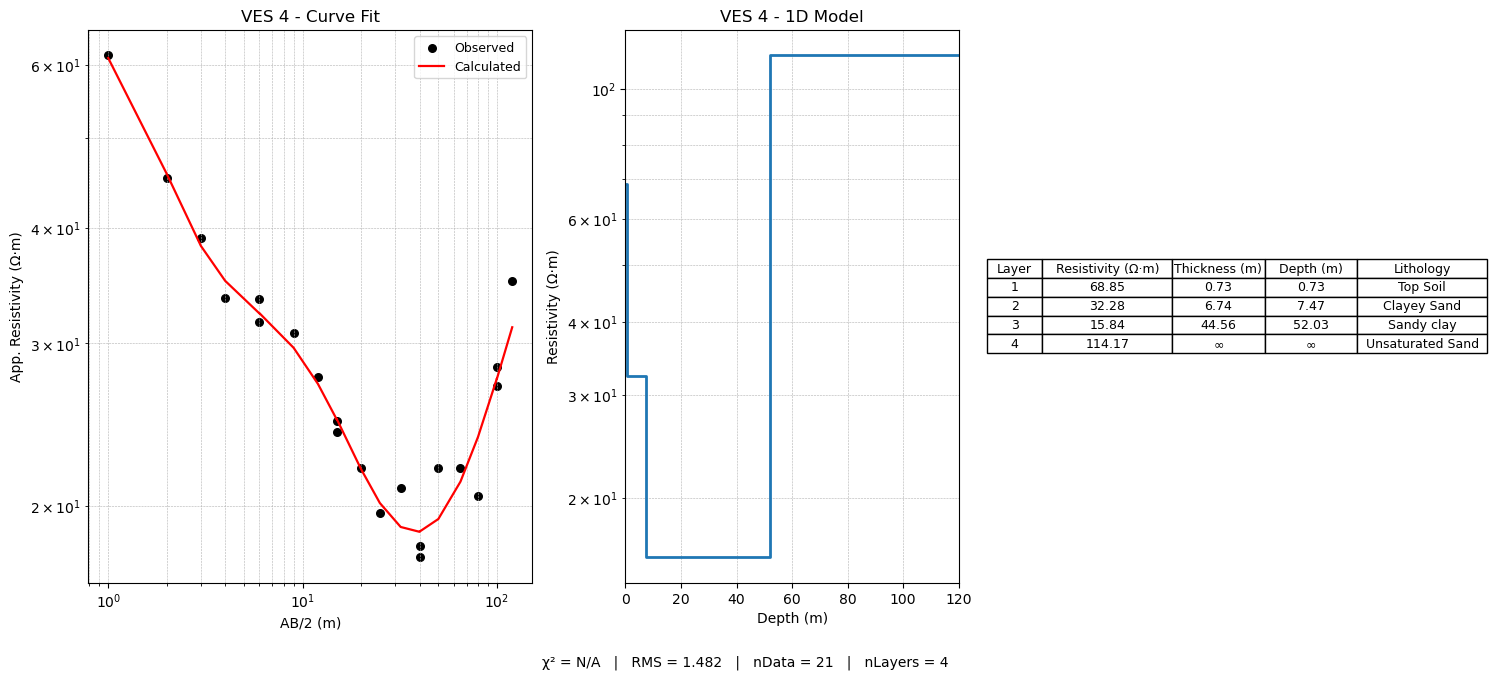

[DONE] Summary saved: C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output\summary.csv


In [22]:
"""
ves_reinv_pygimli_1.5.4

Final script: 3-panel output per sounding (curve | 1D model | layers table)
- First layer lithology forced to "Top Soil"
- Panel 2 swapped: depth on X, resistivity on Y (log scale)
- Includes bottom annotation: χ², RMS, nData, nLayers
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import pygimli as pg
from pygimli.physics.ves import VESManager, VESModelling

# ---------------- CONFIG ----------------
MEASURED_XLSX = r"C:\Users\HOME\Desktop\ML Saline\VES\TR1.xlsx"
ROUGH_XLSX    = r"C:\Users\HOME\Desktop\ML Saline\VES\Pre Intrepreted depth and resistivity.xlsx"
OUT_DIR       = r"C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output"

REL_ERR       = 0.03
DEPTH_FACTOR  = 1.5
LAMBDA        = 20
SHOW_PLOTS    = True

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- HELPERS ----------------

def classify_lithology(res):
    if res < 20:   return "Sandy clay"
    if res < 100:   return "Clayey Sand"
    if res < 500:  return "Unsaturated Sand"
    if res < 3000: return "saturated Sand"
    return "Bedrock"

def fallback_thicknesses(n_layers, max_depth, ratio=2.0):
    if n_layers <= 1:
        return []
    n = n_layers - 1
    if n == 1:
        return [max_depth]
    denom = (ratio**n - 1) / (ratio - 1)
    t0 = max_depth / denom
    return (t0 * ratio**np.arange(n)).tolist()

def _find_col(df, keywords):
    cols = list(df.columns)
    for k in keywords:
        for c in cols:
            if k.lower() in c.lower():
                return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[0] if len(nums) > 0 else None

# ---------------- IO: ROUGH MODELS ----------------

def load_rough_models(path):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] Rough-estimates file not found: {p}  -> proceeding without roughs")
        return {}

    sheets = pd.read_excel(p, sheet_name=None)
    dfs = []
    for sname, df in sheets.items():
        df2 = df.dropna(how="all").reset_index(drop=True)
        if df2.empty:
            continue
        df2['_sheet_name_'] = str(sname)
        dfs.append(df2)
    if not dfs:
        return {}
    big = pd.concat(dfs, ignore_index=True)

    ves_col = _find_col(big, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    res_col = _find_col(big, ['resist', 'res', 'rho'])
    thk_col = _find_col(big, ['thick', 'thk', 'thickness'])

    roughs = {}
    if ves_col is not None and ves_col not in ['_sheet_name_']:
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            res = pd.to_numeric(g[res_col], errors='coerce').dropna().tolist() if res_col else []
            thk = pd.to_numeric(g[thk_col], errors='coerce').dropna().tolist() if thk_col else []
            if res:
                roughs[str(key).strip()] = {'res': res, 'thk': thk}
    else:
        for sname, df in sheets.items():
            d = df.dropna(how='all').reset_index(drop=True)
            if d.empty: continue
            rcol = _find_col(d, ['resist','res','rho'])
            tcol = _find_col(d, ['thick','thk','thickness'])
            res = pd.to_numeric(d[rcol], errors='coerce').dropna().tolist() if rcol else []
            thk = pd.to_numeric(d[tcol], errors='coerce').dropna().tolist() if tcol else []
            if res:
                roughs[str(sname).strip()] = {'res': res, 'thk': thk}

    print(f"[INFO] Loaded rough models for {len(roughs)} VES soundings from {p.name}")
    return roughs

# ---------------- MEASURED DATA LOADER ----------------

def iterate_measured_workbook(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Measured workbook not found: {p}")

    sheets = pd.read_excel(p, sheet_name=None)
    first_df = next(iter(sheets.values())).dropna(how='all').reset_index(drop=True)
    ves_col = _find_col(first_df, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    if ves_col is not None and ves_col in first_df.columns:
        dfs = [df.dropna(how='all').reset_index(drop=True) for df in sheets.values() if not df.dropna(how='all').empty]
        big = pd.concat(dfs, ignore_index=True)
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            yield str(key).strip(), g.reset_index(drop=True)
    else:
        for sname, df in sheets.items():
            yield str(sname).strip(), df.reset_index(drop=True)

# ---------------- INVERSION ----------------

def invert_single(df, ab2_col, rhoa_col, name, roughs):
    df = df.dropna(how="all")
    if ab2_col not in df.columns or rhoa_col not in df.columns:
        return None

    df = df[(pd.to_numeric(df[ab2_col], errors='coerce')>0) & (pd.to_numeric(df[rhoa_col], errors='coerce')>0)].copy()
    if df.empty: return None

    df = df.sort_values(by=ab2_col)
    ab2 = df[ab2_col].astype(float).values
    rhoa = df[rhoa_col].astype(float).values
    mn2 = df.loc[:, df.columns.str.contains('mn2', case=False)].astype(float).values.flatten() if any(df.columns.str.contains('mn2', case=False)) else None

    rough = roughs.get(name.strip())
    if rough and len(rough.get('res', [])) >= 2:
        res0 = list(map(float, rough.get('res', [])))
        thk0 = list(map(float, rough.get('thk', [])))
        nL = len(res0)
        if len(thk0) < nL - 1:
            thk0 = thk0 + fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
            thk0 = thk0[:nL-1]
    else:
        nL = 4
        thk0 = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        median = np.median(rhoa)
        res0 = list(np.logspace(np.log10(max(1.0, median/3.0)), np.log10(median*3.0), nL))

    startModel = np.array(list(thk0) + list(res0), dtype=float)

    ves = VESManager()
    try:
        model = ves.invert(rhoa, ab2=ab2, mn2=mn2, nLayers=nL, startModel=startModel, err=REL_ERR, showProgress=0)
        used_manager = True
    except Exception:
        fop = VESModelling(ab2=ab2, mn2=mn2)
        inv = pg.Inversion(fop=fop, verbose=False)
        model = inv.run(rhoa, lam=LAMBDA, startModel=startModel)
        used_manager = False

    model = np.asarray(model, dtype=float)
    thk_model = model[:nL-1] if len(model) >= (nL-1) else np.array([])
    res_model = model[nL-1:] if len(model) >= nL else model[-nL:]

    rho_calc = None
    try:
        if used_manager:
            rho_calc = ves.fop.response(model)
        else:
            fop = VESModelling(ab2=ab2, mn2=mn2)
            rho_calc = fop.response(model)
    except Exception:
        pass

    depth_tops = np.concatenate([[0.0], np.cumsum(thk_model)]) if len(thk_model)>0 else np.zeros(len(res_model)+1)

    rows = []
    for i, r in enumerate(res_model):
        thick = float(thk_model[i]) if i < len(thk_model) else None
        depth = float(depth_tops[i+1]) if i < len(thk_model) else None
        lith = "Top Soil" if i == 0 else classify_lithology(float(r))
        rows.append({
            "layer": i+1,
            "resistivity_ohm_m": float(r),
            "thickness_m": thick,
            "depth_m": depth,
            "lithology": lith
        })

    chi2 = None; rms = None
    try:
        if used_manager:
            chi2 = ves.chi2(model)
            rms = np.sqrt(chi2 / max(1, len(rhoa)))
        elif rho_calc is not None:
            diff = (rhoa - rho_calc)
            rms = np.sqrt(np.mean(diff**2))
            chi2 = float('nan')
    except Exception:
        pass

    return {
        "rows": rows,
        "ab2": ab2,
        "rhoa": rhoa,
        "rho_calc": rho_calc,
        "nLayers": len(res_model),
        "chi2": chi2,
        "rms": rms
    }

# ---------------- MAIN ----------------

def process(measured_xlsx, roughs_xlsx, out_dir):
    roughs = load_rough_models(roughs_xlsx) if roughs_xlsx else {}
    summary = []

    for ves_key, df in iterate_measured_workbook(measured_xlsx):
        ab2_col = _find_col(df, ['ab2','ab/2'])
        rhoa_col = _find_col(df, ['rho','rhoa','rho_a','app'])
        result = invert_single(df, ab2_col, rhoa_col, ves_key, roughs)
        if not result: continue

        out_folder = Path(out_dir) / str(ves_key)
        out_folder.mkdir(parents=True, exist_ok=True)

        df_layers = pd.DataFrame(result["rows"])
        df_layers.to_csv(out_folder / f"{ves_key}_layers.csv", index=False)

        # 3-panel plot
        fig, axes = plt.subplots(1, 3, figsize=(15,7), gridspec_kw={'width_ratios':[1.2,0.9,1]})

        # Panel 1: curve
        ax0 = axes[0]
        ax0.scatter(result["ab2"], result["rhoa"], c="k", s=30, label="Observed")
        if result["rho_calc"] is not None:
            ax0.plot(result["ab2"], result["rho_calc"], 'r-', linewidth=1.6, label="Calculated")
        ax0.set_xscale("log"); ax0.set_yscale("log")
        ax0.set_xlabel("AB/2 (m)"); ax0.set_ylabel("App. Resistivity (Ω·m)")
        ax0.set_title(f"VES {ves_key} - Curve Fit")
        ax0.legend(fontsize=9); ax0.grid(True, which="both", ls="--", lw=0.4)

        # Panel 2: depth (X) vs resistivity (Y)
        ax1 = axes[1]
        res_vals = [r['resistivity_ohm_m'] for r in result['rows']]
        thk_vals = [r['thickness_m'] for r in result['rows'] if r['thickness_m'] is not None]
        depth_tops = [0.0] + list(np.cumsum(thk_vals)) if thk_vals else [0.0]*(len(res_vals))
        depths_plot = []
        rhos_plot = []
        for i, rv in enumerate(res_vals):
            top = depth_tops[i] if i < len(depth_tops) else 0.0
            bottom = depth_tops[i+1] if (i+1) < len(depth_tops) else max(result["ab2"])
            depths_plot.extend([top, bottom])
            rhos_plot.extend([rv, rv])
        ax1.semilogy(depths_plot, rhos_plot, linewidth=2)
        ax1.set_xlim(0, max(depths_plot))
        ax1.set_xlabel("Depth (m)")
        ax1.set_ylabel("Resistivity (Ω·m)")
        ax1.set_title(f"VES {ves_key} - 1D Model")
        ax1.grid(True, which="both", ls="--", lw=0.4)

        # Panel 3: table
        ax2 = axes[2]; ax2.axis('off')
        rows_table = [["Layer","Resistivity (Ω·m)","Thickness (m)","Depth (m)","Lithology"]]
        for r in result['rows']:
            t = f"{r['thickness_m']:.2f}" if r['thickness_m'] is not None else "∞"
            d = f"{r['depth_m']:.2f}" if r['depth_m'] is not None else "∞"
            rows_table.append([r['layer'], f"{r['resistivity_ohm_m']:.2f}", t, d, r['lithology']])
        tbl = ax2.table(cellText=rows_table, cellLoc='center', loc='center', colWidths=[0.15,0.35,0.25,0.25,0.35])
        tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.1)

        # misfit annotation
        chi2 = result.get('chi2'); rms = result.get('rms')
        chi2_str = f"{chi2:.2f}" if chi2 is not None and not (isinstance(chi2,float) and np.isnan(chi2)) else "N/A"
        rms_str = f"{rms:.3f}" if rms is not None and not (isinstance(rms,float) and np.isnan(rms)) else "N/A"
        txt = f"χ² = {chi2_str}   |   RMS = {rms_str}   |   nData = {len(result['rhoa'])}   |   nLayers = {result['nLayers']}"
        fig.text(0.5, 0.01, txt, ha='center', fontsize=10)

        fig.tight_layout(rect=[0,0.04,1,0.97])
        fig.savefig(out_folder / f"{ves_key}_panel.png", dpi=200)
        if SHOW_PLOTS: plt.show()
        plt.close(fig)

        summary.append({"VES":ves_key,"nLayers":result["nLayers"],"chi2":result["chi2"],"rms":result["rms"],"out_folder":str(out_folder)})

    pd.DataFrame(summary).to_csv(Path(out_dir)/"summary.csv", index=False)
    print(f"[DONE] Summary saved: {Path(out_dir)/'summary.csv'}")

if __name__ == "__main__":
    process(MEASURED_XLSX, ROUGH_XLSX, OUT_DIR)


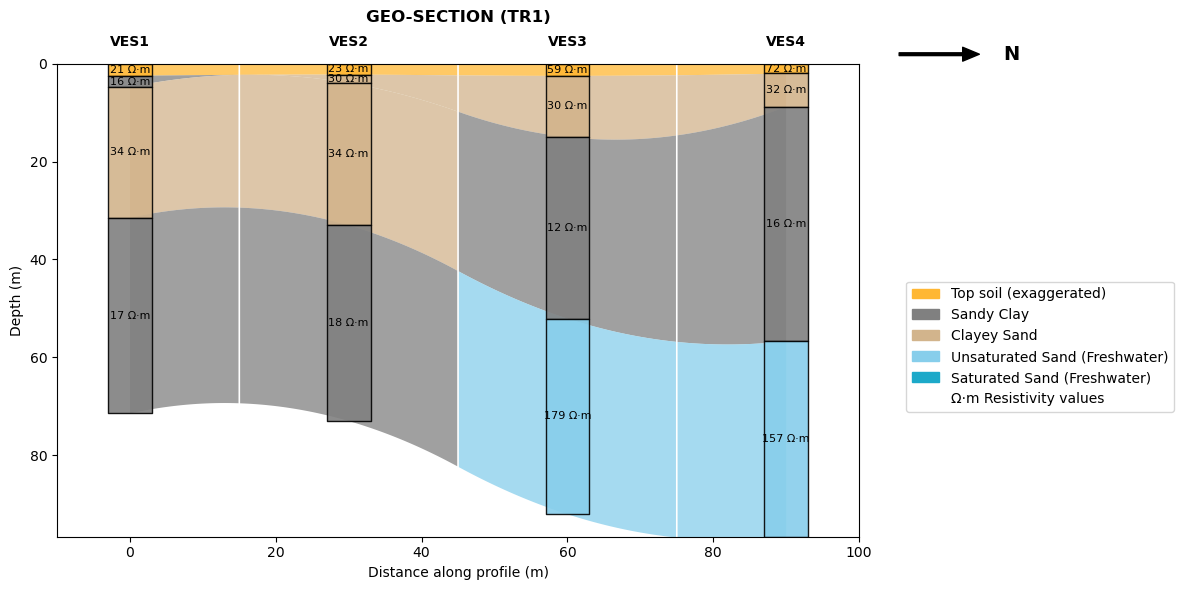

Figure saved at: C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS\GEO_SECTION_TR1.png


In [7]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
import matplotlib.patches as mpatches  
from scipy.interpolate import make_interp_spline  
import os  

# -------------------------------  
# CONFIGURATION  
# -------------------------------  
excel_file = r"C:\\Users\\HOME\\Desktop\\ML Saline\\VES\\TR 1 Summary.xlsx"  
ves_positions = {"VES1": 0, "VES2": 30, "VES3": 60, "VES4": 90}  

profile_name = "TR1"  
topsoil_exaggeration = 2.5  # exaggerate topsoil thickness ×1.5  

# -------------------------------  
# Lithology classification  
# -------------------------------  
def classify_lithology(rho, is_top=False):  
    if is_top:  
        return "Topsoil", "#FFB733", -1  # yellowish-orange  
    if rho < 20:  
        return "Sandy Clay", "grey", 0  
    elif 20 <= rho < 100:  
        return "Clayey Sand", "tan", 1  
    elif 60 <= rho < 500:  
        return "Unsaturatd Sand (Freshwater)", "skyblue", 2  
    elif rho >= 500:  
        return "Saturated Sand (Freshwater)", "#1CA9C9", 3   
    else:  
        return "Resitivity Value", "black", 4  
        
# -------------------------------  
# Read Excel file (multiple sheets)  
# -------------------------------  
ves_data = {}  
xls = pd.ExcelFile(excel_file)  

for sheet in xls.sheet_names:  
    df = pd.read_excel(excel_file, sheet_name=sheet)  
    res = pd.to_numeric(df["resistivity"], errors="coerce").tolist()  
    thk = pd.to_numeric(df["thickness"], errors="coerce").tolist()  

    # exaggerate topsoil thickness (only first layer)  
    if thk and not pd.isna(thk[0]):  
        thk[0] *= topsoil_exaggeration  

    key = sheet.replace(" ", "")  # normalize  
    ves_data[key] = {  
        "x": ves_positions[key],  
        "res": res,  
        "thk": [None if pd.isna(v) else v for v in thk]  
    }  

# -------------------------------  
# Step 1: Extract layer interfaces across all VES  
# -------------------------------  
layer_surfaces = []  
max_depth = 0  

for ves, data in ves_data.items():  
    depth = 0  
    surfaces = [0]  # start at ground surface  
    for h in data["thk"]:  
        h_val = h if h else 40  
        depth += h_val  
        surfaces.append(depth)  
    layer_surfaces.append(surfaces)  
    max_depth = max(max_depth, depth)  

# pad so all VES have same number of interfaces  
max_layers = max(len(s) for s in layer_surfaces)  
for s in layer_surfaces:  
    while len(s) < max_layers:  
        s.append(s[-1])  

layer_surfaces = list(map(list, zip(*layer_surfaces)))  # transpose  

# -------------------------------  
# Step 2: Smooth interpolate each interface  
# -------------------------------  
x_coords = list(ves_positions.values())  
xs_dense = np.linspace(min(x_coords), max(x_coords), 400)  

smooth_surfaces = []  
for surface in layer_surfaces:  
    spline = make_interp_spline(x_coords, surface, k=2)  
    smooth_surfaces.append(spline(xs_dense))  

# -------------------------------  
# Step 3: Determine lithology for each VES at each layer  
# -------------------------------  
ves_lithologies = {}  
for ves, data in ves_data.items():  
    lithologies = []  
    for i, rho in enumerate(data["res"]):  
        is_top = (i == 0)  
        lith, color, code = classify_lithology(rho, is_top=is_top)  
        lithologies.append((lith, color, code))  
    ves_lithologies[ves] = lithologies

# Pad lithologies to max_layers
for ves in ves_lithologies:
    current_lithologies = ves_lithologies[ves]
    if len(current_lithologies) < max_layers:
        last_lithology = current_lithologies[-1] if current_lithologies else ("Resistivity Value", "black", 4)
        ves_lithologies[ves].extend([last_lithology] * (max_layers - len(current_lithologies)))

# -------------------------------  
# Step 4: Create segments for continuous lithology filling
# -------------------------------  
# Create breakpoints at midpoints between VES stations
ves_x_sorted = sorted(ves_positions.values())
breakpoints = []
for i in range(len(ves_x_sorted)-1):
    breakpoints.append((ves_x_sorted[i] + ves_x_sorted[i+1]) / 2)

# Create segments with assigned VES
segments = []
segments.append((ves_x_sorted[0] - 15, breakpoints[0], list(ves_positions.keys())[0]))  # Leftmost segment
for i in range(len(breakpoints)-1):
    segments.append((breakpoints[i], breakpoints[i+1], list(ves_positions.keys())[i+1]))
segments.append((breakpoints[-1], ves_x_sorted[-1] + 15, list(ves_positions.keys())[-1]))  # Rightmost segment

# -------------------------------  
# Step 5: Plot smooth filled layers with proper continuity
# -------------------------------  
fig, ax = plt.subplots(figsize=(12, 6))  

# Fill background by segments
for seg in segments:
    x_start, x_end, ves_name = seg
    seg_indices = np.where((xs_dense >= x_start) & (xs_dense <= x_end))[0]
    
    if len(seg_indices) == 0:
        continue
        
    x_seg = xs_dense[seg_indices]
    
    for i in range(len(smooth_surfaces) - 1):
        top = smooth_surfaces[i][seg_indices]
        bottom = smooth_surfaces[i+1][seg_indices]
        
        # Get lithology for this VES and layer
        if i < len(ves_lithologies[ves_name]):
            lith, color, _ = ves_lithologies[ves_name][i]
        else:
            lith, color, _ = classify_lithology(50)  # Default
            
        ax.fill_between(x_seg, top, bottom, color=color, edgecolor="none", alpha=0.75)

# Overlay VES bars with consistent colors
for ves, data in ves_data.items():  
    x = data["x"]  
    depth = 0  
    for i, rho in enumerate(data["res"]):  
        h = data["thk"][i] if data["thk"][i] else 40  
        bottom = depth + h  
        is_top = (i == 0)  
        lith, color, _ = classify_lithology(rho, is_top=is_top)  
        ax.fill_between([x-3, x+3], depth, bottom, color=color, edgecolor="k", alpha=0.9)  
        ax.text(x, (depth+bottom)/2, f"{rho:.0f} Ω·m", ha="center", va="center", fontsize=8)  
        depth = bottom  
    ax.text(x, -3, ves, ha="center", va="bottom", fontsize=10, fontweight="bold")  

# -------------------------------  
# Axis labels & title  
# -------------------------------  
ax.set_xlabel("Distance along profile (m)")  
ax.set_ylabel("Depth (m)")  
ax.set_title(f"GEO-SECTION ({profile_name})", pad=30, fontweight="bold")  

ax.set_ylim(max_depth, 0)  
ax.set_xlim(min(x_coords)-10, max(x_coords)+10)  

# -------------------------------  
# North arrow (top-right, inline, pointing left)  
# -------------------------------  
ax.annotate('', xy=(1.15, 1.02), xytext=(1.05, 1.02),  
            xycoords='axes fraction',  
            arrowprops=dict(facecolor='black', width=2, headwidth=10))  

ax.text(1.18, 1.02, 'N', transform=ax.transAxes,  
        ha='left', va='center', fontsize=14, fontweight='bold')  

# -------------------------------  
# Legend  
# -------------------------------  
legend_patches = [
    mpatches.Patch(color="#FFB733", label="Top soil (exaggerated)"),
    mpatches.Patch(color="grey", label="Sandy Clay"),
    mpatches.Patch(color="tan", label="Clayey Sand"),
    mpatches.Patch(color="skyblue", label="Unsaturated Sand (Freshwater)"),
    mpatches.Patch(color="#1CA9C9", label="Saturated Sand (Freshwater)"),
    mpatches.Patch(facecolor="white", edgecolor="none", label="Ω·m Resistivity values")
]  
ax.legend(handles=legend_patches, loc="lower left",  
          bbox_to_anchor=(1.05, 0.25), frameon=True)  

plt.tight_layout()  

# -------------------------------
# SAVE FIGURE TO FOLDER
# -------------------------------
output_dir = r"C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS"  # raw string for Windows path
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"GEO_SECTION_{profile_name}.png")

plt.savefig(output_path, dpi=300, bbox_inches="tight")  
plt.show()  

print(f"Figure saved at: {output_path}")  

#### TRAVERSE 2

10/10/25 - 16:30:26 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:26 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


[INFO] Loaded rough models for 20 VES soundings from Pre Intrepreted depth and resistivity.xlsx


10/10/25 - 16:30:26 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:26 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:26 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:26 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


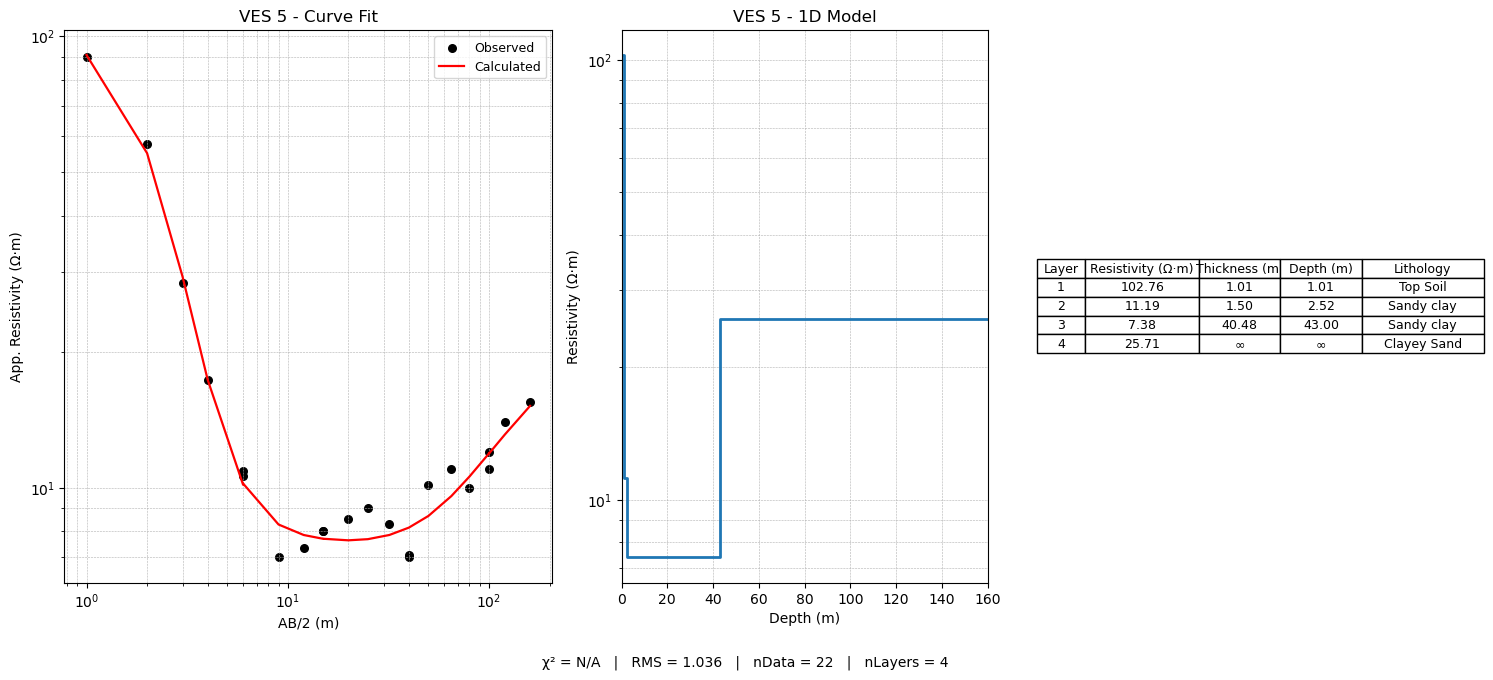

10/10/25 - 16:30:28 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:28 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:28 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


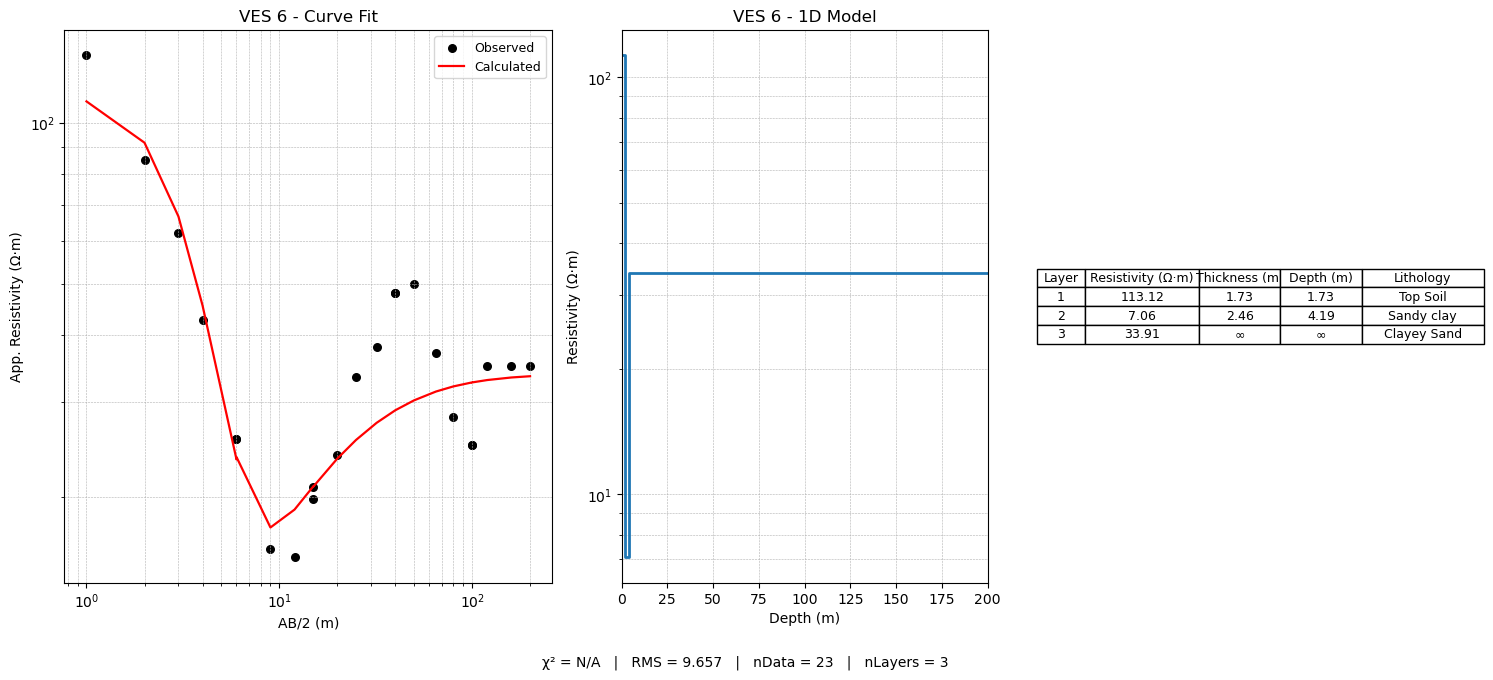

10/10/25 - 16:30:31 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:31 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:31 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


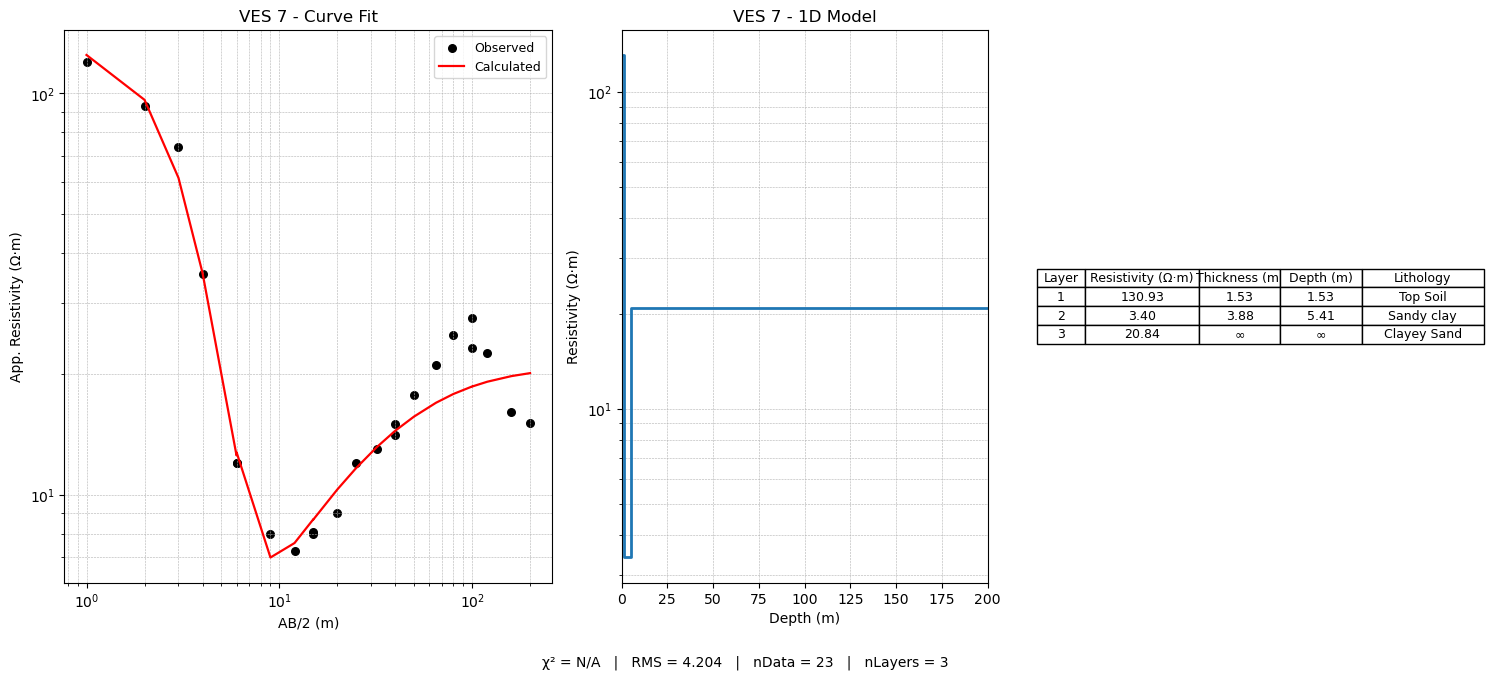

10/10/25 - 16:30:33 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:33 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:33 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:33 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


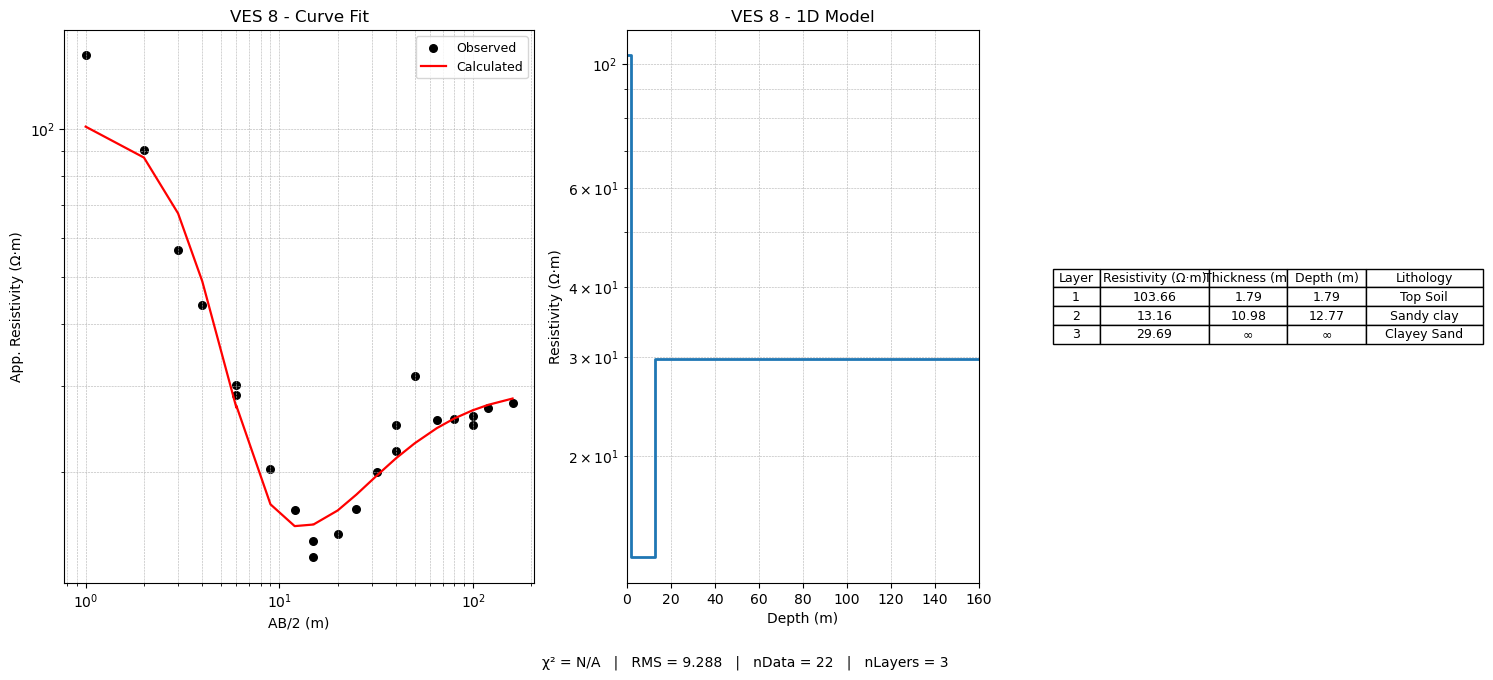

[DONE] Summary saved: C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output\summary.csv


In [8]:
"""
ves_reinv_pygimli_1.5.4  (fixed: no calls to fop.modelSize(); robust startModel sizing)

This is a drop-in replacement for your script. It forces agreement between the
start model size and the expected parameter vector size (2*nLayers - 1) and
handles 3, 4, 5 (and other) layer start models robustly.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import pygimli as pg
from pygimli.physics.ves import VESManager, VESModelling

# ---------------- CONFIG ----------------
MEASURED_XLSX = r"C:\Users\HOME\Desktop\ML Saline\VES\TR2.xlsx"
ROUGH_XLSX    = r"C:\Users\HOME\Desktop\ML Saline\VES\Pre Intrepreted depth and resistivity.xlsx"
OUT_DIR       = r"C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output"

REL_ERR       = 0.03
DEPTH_FACTOR  = 1.5
LAMBDA        = 20
SHOW_PLOTS    = True

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- HELPERS ----------------

def classify_lithology(res):
    if res < 20:   return "Sandy clay"
    if res < 100:   return "Clayey Sand"
    if res < 500:  return "Unsaturated Sand"
    if res < 3000: return "saturated Sand"
    return "Bedrock"


def fallback_thicknesses(n_layers, max_depth, ratio=2.0):
    """
    Return n_layers-1 thicknesses that approximately sum to max_depth.
    """
    if n_layers <= 1:
        return []
    n = n_layers - 1
    if n == 1:
        return [max_depth]
    denom = (ratio**n - 1) / (ratio - 1)
    t0 = max_depth / denom
    return (t0 * ratio**np.arange(n)).tolist()

def _find_col(df, keywords):
    cols = list(df.columns)
    for k in keywords:
        for c in cols:
            if k.lower() in c.lower():
                return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[0] if len(nums) > 0 else None

# ---------------- IO: ROUGH MODELS ----------------

def load_rough_models(path):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] Rough-estimates file not found: {p}  -> proceeding without roughs")
        return {}

    sheets = pd.read_excel(p, sheet_name=None)
    dfs = []
    for sname, df in sheets.items():
        df2 = df.dropna(how="all").reset_index(drop=True)
        if df2.empty:
            continue
        df2['_sheet_name_'] = str(sname)
        dfs.append(df2)
    if not dfs:
        return {}
    big = pd.concat(dfs, ignore_index=True)

    ves_col = _find_col(big, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    res_col = _find_col(big, ['resist', 'res', 'rho'])
    thk_col = _find_col(big, ['thick', 'thk', 'thickness'])

    roughs = {}
    if ves_col is not None and ves_col not in ['_sheet_name_']:
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            res = pd.to_numeric(g[res_col], errors='coerce').dropna().tolist() if res_col else []
            thk = pd.to_numeric(g[thk_col], errors='coerce').dropna().tolist() if thk_col else []
            if res:
                roughs[str(key).strip()] = {'res': res, 'thk': thk}
    else:
        for sname, df in sheets.items():
            d = df.dropna(how='all').reset_index(drop=True)
            if d.empty: continue
            rcol = _find_col(d, ['resist','res','rho'])
            tcol = _find_col(d, ['thick','thk','thickness'])
            res = pd.to_numeric(d[rcol], errors='coerce').dropna().tolist() if rcol else []
            thk = pd.to_numeric(d[tcol], errors='coerce').dropna().tolist() if tcol else []
            if res:
                roughs[str(sname).strip()] = {'res': res, 'thk': thk}

    print(f"[INFO] Loaded rough models for {len(roughs)} VES soundings from {p.name}")
    return roughs

# ---------------- MEASURED DATA LOADER ----------------

def iterate_measured_workbook(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Measured workbook not found: {p}")

    sheets = pd.read_excel(p, sheet_name=None)
    first_df = next(iter(sheets.values())).dropna(how='all').reset_index(drop=True)
    ves_col = _find_col(first_df, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    if ves_col is not None and ves_col in first_df.columns:
        dfs = [df.dropna(how='all').reset_index(drop=True) for df in sheets.values() if not df.dropna(how='all').empty]
        big = pd.concat(dfs, ignore_index=True)
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            yield str(key).strip(), g.reset_index(drop=True)
    else:
        for sname, df in sheets.items():
            yield str(sname).strip(), df.reset_index(drop=True)

# ---------------- INVERSION ----------------

def build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=None):
    """
    Ensure startModel is exactly the expected size. Expected size for nL layers
    is 2*nL - 1 (nL resistivities + nL-1 thicknesses).
    """
    target_thk_len = max(0, nL - 1)
    target_res_len = nL

    thk = list(map(float, thk0)) if thk0 is not None else []
    res = list(map(float, res0)) if res0 is not None else []

    if len(thk) < target_thk_len:
        more = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        thk = (thk + more)[:target_thk_len]

    if len(res) < target_res_len:
        last = res[-1] if len(res) > 0 else float(np.median(rhoa) if len(rhoa)>0 else 100.0)
        while len(res) < target_res_len:
            res.append(last)

    thk = thk[:target_thk_len]
    res = res[:target_res_len]

    start = np.array(list(thk) + list(res), dtype=float)

    # Do NOT rely on fop.modelSize(); compute expected size directly:
    expected_size = 2 * nL - 1
    # If fop provides a model-size-like attribute (rare), try to use it (safe guard)
    try:
        if fop is not None:
            if hasattr(fop, 'modelSize'):
                expected_size = int(fop.modelSize())
            elif hasattr(fop, 'size'):
                expected_size = int(fop.size())
    except Exception:
        expected_size = 2 * nL - 1

    # Adjust if mismatch
    if len(start) != expected_size:
        missing = expected_size - len(start)
        if missing > 0:
            # Prefer adding small thicknesses first, then resistivities
            while len(thk) < target_thk_len and len(start) < expected_size:
                thk.append(max(0.1, np.mean(thk) if len(thk)>0 else max(ab2)*0.05))
                start = np.array(list(thk) + list(res), dtype=float)
            while len(res) < target_res_len and len(start) < expected_size:
                res.append(res[-1] if len(res)>0 else (np.median(rhoa) if len(rhoa)>0 else 100.0))
                start = np.array(list(thk) + list(res), dtype=float)
        elif missing < 0:
            # truncate extras (prefer truncating extra thicknesses)
            thk = thk[:target_thk_len]
            res = res[:target_res_len]
            start = np.array(list(thk) + list(res), dtype=float)

    # final safety pad/truncate
    if len(start) != expected_size:
        if len(start) < expected_size:
            pad_val = np.median(rhoa) if len(rhoa)>0 else 100.0
            start = np.concatenate([start, np.full(expected_size - len(start), pad_val)])
        else:
            start = start[:expected_size]

    return start, thk, res

def invert_single(df, ab2_col, rhoa_col, name, roughs):
    df = df.dropna(how="all")
    if ab2_col not in df.columns or rhoa_col not in df.columns:
        return None

    df = df[(pd.to_numeric(df[ab2_col], errors='coerce')>0) & (pd.to_numeric(df[rhoa_col], errors='coerce')>0)].copy()
    if df.empty: return None

    df = df.sort_values(by=ab2_col)
    ab2 = df[ab2_col].astype(float).values
    rhoa = df[rhoa_col].astype(float).values
    mn2 = df.loc[:, df.columns.str.contains('mn2', case=False)].astype(float).values.flatten() if any(df.columns.str.contains('mn2', case=False)) else None

    rough = roughs.get(str(name).strip())
    if rough and len(rough.get('res', [])) >= 2:
        res0 = list(map(float, rough.get('res', [])))
        thk0 = list(map(float, rough.get('thk', [])))
        nL = len(res0)
        if nL < 2:
            nL = 2
        if len(thk0) < nL - 1:
            thk0 = thk0 + fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
            thk0 = thk0[:nL-1]
    else:
        nL = 4
        thk0 = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        median = np.median(rhoa) if len(rhoa)>0 else 100.0
        res0 = list(np.logspace(np.log10(max(1.0, median/3.0)), np.log10(median*3.0), nL))

    if nL < 2:
        nL = 2

    # Build a fop object for sizing check when possible (not required)
    try:
        fop_check = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
    except Exception:
        fop_check = None

    startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=fop_check)

    model = None
    used_manager = False
    try:
        fop = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
        expected = 2 * nL - 1
        # final size guarantee
        if len(startModel) != expected:
            startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop)

        inv = pg.Inversion(fop=fop, verbose=False)
        model = inv.run(rhoa, lam=LAMBDA, startModel=startModel)
        used_manager = False
    except Exception as e:
        # fallback to VESManager wrapper
        try:
            vm = VESManager()
            model = vm.invert(rhoa, ab2=ab2, mn2=mn2, startModel=startModel, err=REL_ERR, showProgress=0)
            used_manager = True
        except Exception as e2:
            # last fallback: try VESModelling without nLayers
            try:
                fop2 = VESModelling(ab2=ab2, mn2=mn2)
                startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop2)
                inv2 = pg.Inversion(fop=fop2, verbose=False)
                model = inv2.run(rhoa, lam=LAMBDA, startModel=startModel)
                used_manager = False
            except Exception as e3:
                print(f"[ERROR] Inversion failed for VES {name}. Exceptions:\n primary: {e}\n fallback1: {e2}\n fallback2: {e3}")
                return None

    model = np.asarray(model, dtype=float)

    # slice thicknesses and resistivities robustly
    if len(model) >= (nL - 1):
        thk_model = model[:max(0, nL-1)]
    else:
        thk_model = np.array([])

    if len(model) >= (len(thk_model) + nL):
        res_model = model[len(thk_model):len(thk_model)+nL]
    elif len(model) >= nL:
        res_model = model[-nL:]
    else:
        # fallback: try to consider last elements as resistivities
        res_model = model if len(model)>0 else np.array([np.median(rhoa) if len(rhoa)>0 else 100.0])

    # try compute forward response
    rho_calc = None
    try:
        if used_manager and 'vm' in locals() and hasattr(vm, 'fop') and vm.fop is not None:
            try:
                rho_calc = vm.fop.response(model)
            except Exception:
                rho_calc = None
        elif 'fop' in locals():
            try:
                rho_calc = fop.response(model)
            except Exception:
                rho_calc = None
    except Exception:
        rho_calc = None

    # depth tops
    depth_tops = np.concatenate([[0.0], np.cumsum(thk_model)]) if len(thk_model)>0 else np.array([0.0, max(ab2)])

    rows = []
    for i, r in enumerate(res_model):
        thick = float(thk_model[i]) if i < len(thk_model) else None
        depth = float(depth_tops[i+1]) if (i+1) < len(depth_tops) else (float(depth_tops[-1]) if len(depth_tops)>0 else None)
        lith = "Top Soil" if i == 0 else classify_lithology(float(r))
        rows.append({
            "layer": i+1,
            "resistivity_ohm_m": float(r),
            "thickness_m": thick,
            "depth_m": depth,
            "lithology": lith
        })

    chi2 = None; rms = None
    try:
        if used_manager and 'vm' in locals():
            if hasattr(vm, 'chi2'):
                try:
                    chi2 = vm.chi2(model)
                    rms = np.sqrt(chi2 / max(1, len(rhoa)))
                except Exception:
                    chi2 = None
            else:
                # compute residuals if possible
                if rho_calc is not None:
                    diff = (rhoa - rho_calc)
                    rms = np.sqrt(np.mean(diff**2))
                    chi2 = float('nan')
        else:
            if rho_calc is not None:
                diff = (rhoa - rho_calc)
                rms = np.sqrt(np.mean(diff**2))
                chi2 = float('nan')
    except Exception:
        pass

    return {
        "rows": rows,
        "ab2": ab2,
        "rhoa": rhoa,
        "rho_calc": rho_calc,
        "nLayers": len(res_model),
        "chi2": chi2,
        "rms": rms
    }

# ---------------- MAIN ----------------

def process(measured_xlsx, roughs_xlsx, out_dir):
    roughs = load_rough_models(roughs_xlsx) if roughs_xlsx else {}
    summary = []

    for ves_key, df in iterate_measured_workbook(measured_xlsx):
        ab2_col = _find_col(df, ['ab2','ab/2'])
        rhoa_col = _find_col(df, ['rho','rhoa','rho_a','app'])
        result = invert_single(df, ab2_col, rhoa_col, ves_key, roughs)
        if not result:
            print(f"[WARN] Skipping VES {ves_key} (inversion returned nothing).")
            continue

        out_folder = Path(out_dir) / str(ves_key)
        out_folder.mkdir(parents=True, exist_ok=True)

        df_layers = pd.DataFrame(result["rows"])
        df_layers.to_csv(out_folder / f"{ves_key}_layers.csv", index=False)

        # 3-panel plot
        fig, axes = plt.subplots(1, 3, figsize=(15,7), gridspec_kw={'width_ratios':[1.2,0.9,1]})

        # Panel 1: curve
        ax0 = axes[0]
        ax0.scatter(result["ab2"], result["rhoa"], c="k", s=30, label="Observed")
        if result["rho_calc"] is not None:
            ax0.plot(result["ab2"], result["rho_calc"], 'r-', linewidth=1.6, label="Calculated")
        ax0.set_xscale("log"); ax0.set_yscale("log")
        ax0.set_xlabel("AB/2 (m)"); ax0.set_ylabel("App. Resistivity (Ω·m)")
        ax0.set_title(f"VES {ves_key} - Curve Fit")
        ax0.legend(fontsize=9); ax0.grid(True, which="both", ls="--", lw=0.4)

        # Panel 2: depth (X) vs resistivity (Y)
        ax1 = axes[1]
        res_vals = [r['resistivity_ohm_m'] for r in result['rows']]
        thk_vals = [r['thickness_m'] for r in result['rows'] if r['thickness_m'] is not None]
        depth_tops = [0.0] + list(np.cumsum(thk_vals)) if thk_vals else [0.0]*(len(res_vals)+1)
        depths_plot = []
        rhos_plot = []
        for i, rv in enumerate(res_vals):
            top = depth_tops[i] if i < len(depth_tops) else 0.0
            bottom = depth_tops[i+1] if (i+1) < len(depth_tops) else max(result["ab2"])
            depths_plot.extend([top, bottom])
            rhos_plot.extend([rv, rv])
        if len(depths_plot) == 0:
            depths_plot = [0.0, max(result["ab2"])]
            rhos_plot = [res_vals[0] if res_vals else 100.0, res_vals[0] if res_vals else 100.0]
        ax1.semilogy(depths_plot, rhos_plot, linewidth=2)
        ax1.set_xlim(0, max(depths_plot))
        ax1.set_xlabel("Depth (m)")
        ax1.set_ylabel("Resistivity (Ω·m)")
        ax1.set_title(f"VES {ves_key} - 1D Model")
        ax1.grid(True, which="both", ls="--", lw=0.4)

        # Panel 3: table
        ax2 = axes[2]; ax2.axis('off')
        rows_table = [["Layer","Resistivity (Ω·m)","Thickness (m)","Depth (m)","Lithology"]]
        for i, r in enumerate(result['rows']):
            t = f"{r['thickness_m']:.2f}" if r['thickness_m'] is not None else "∞"
            # 👇 Force last row depth to ∞
            if i == len(result['rows']) - 1:
                d = "∞"
            else:
                d = f"{r['depth_m']:.2f}" if r['depth_m'] is not None else "∞"
            rows_table.append([r['layer'], f"{r['resistivity_ohm_m']:.2f}", t, d, r['lithology']])
        tbl = ax2.table(cellText=rows_table, cellLoc='center', loc='center', colWidths=[0.12,0.28,0.20,0.20,0.30])
        tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.1)

        # misfit annotation
        chi2 = result.get('chi2'); rms = result.get('rms')
        chi2_str = f"{chi2:.2f}" if chi2 is not None and not (isinstance(chi2,float) and np.isnan(chi2)) else "N/A"
        rms_str = f"{rms:.3f}" if rms is not None and not (isinstance(rms,float) and np.isnan(rms)) else "N/A"
        txt = f"χ² = {chi2_str}   |   RMS = {rms_str}   |   nData = {len(result['rhoa'])}   |   nLayers = {result['nLayers']}"
        fig.text(0.5, 0.01, txt, ha='center', fontsize=10)

        fig.tight_layout(rect=[0,0.04,1,0.97])
        fig.savefig(out_folder / f"{ves_key}_panel.png", dpi=200)
        if SHOW_PLOTS: plt.show()
        plt.close(fig)

        summary.append({"VES":ves_key,"nLayers":result["nLayers"],"chi2":result["chi2"],"rms":result["rms"],"out_folder":str(out_folder)})

    pd.DataFrame(summary).to_csv(Path(out_dir)/"summary.csv", index=False)
    print(f"[DONE] Summary saved: {Path(out_dir)/'summary.csv'}")

if __name__ == "__main__":
    process(MEASURED_XLSX, ROUGH_XLSX, OUT_DIR)


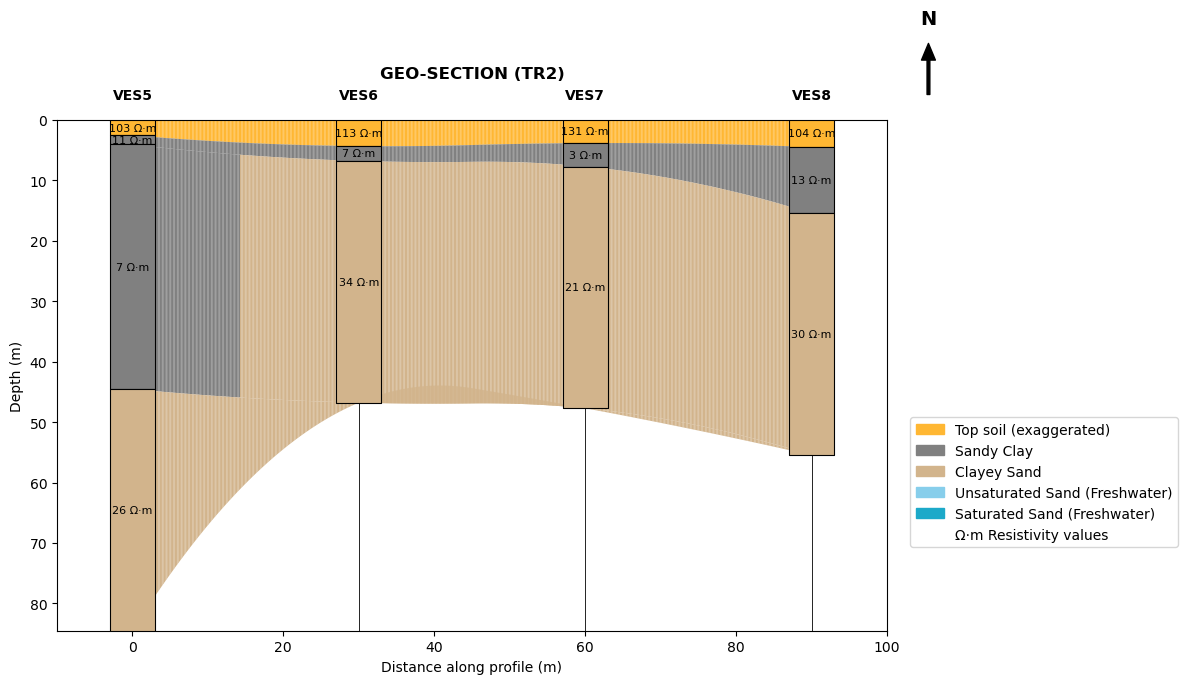

Saved to: C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS\GEO_SECTION_TR2.png


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from scipy.interpolate import make_interp_spline

# -------------------------------
# CONFIGURATION
# -------------------------------
excel_file = r"C:\Users\HOME\Desktop\ML Saline\VES\TR 2 Summary.xlsx"
ves_positions = {"VES5": 0, "VES6": 30, "VES7": 60, "VES8": 90}

profile_name = "TR2"
topsoil_exaggeration = 2.5  # visual exaggeration applied only to plotting

output_dir = r"C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------
# Lithology classification
# (returns label, color, code)
# -------------------------------
def classify_lithology(rho, is_top=False):  
    if is_top:  
        return "Topsoil", "#FFB733", -1  # yellowish-orange  
    if rho < 20:  
        return "Sandy Clay", "grey", 0  
    elif 20 <= rho < 100:  
        return "Clayey Sand", "tan", 1  
    elif 60 <= rho < 500:  
        return "Unsaturatd Sand (Freshwater)", "skyblue", 2  
    elif rho >= 500:  
        return "Saturated Sand (Freshwater)", "#1CA9C9", 3   
    else:  
        return "Resitivity Value", "black", 4    

# -------------------------------
# Read Excel file (multiple sheets)
# Each sheet must contain columns: 'resistivity' and 'thickness'
# -------------------------------
ves_data = {}
xls = pd.ExcelFile(excel_file)
for sheet in xls.sheet_names:
    df = pd.read_excel(excel_file, sheet_name=sheet)
    res = pd.to_numeric(df["resistivity"], errors="coerce").tolist()
    thk = pd.to_numeric(df["thickness"], errors="coerce").tolist()

    # Don't modify original data file — we only apply exaggeration for plotting
    thk_plot = [None if pd.isna(v) else float(v) for v in thk]
    if len(thk_plot) > 0 and thk_plot[0] is not None:
        thk_plot[0] = thk_plot[0] * topsoil_exaggeration

    key = sheet.replace(" ", "")  # normalize sheet name to match ves_positions keys
    ves_data[key] = {
        "x": ves_positions[key],
        "res": [float(r) for r in res],
        "thk": thk_plot
    }

# -------------------------------
# Build ordered lists (ensure ordering by x coordinate)
# -------------------------------
ordered_keys = sorted(ves_positions.keys(), key=lambda k: ves_positions[k])
x_coords = [ves_positions[k] for k in ordered_keys]

# build surfaces per ordered key (interfaces at each VES)
surfaces_per_ves = []
max_depth = 0
for k in ordered_keys:
    data = ves_data[k]
    depth = 0.0
    surfaces = [0.0]
    for h in data["thk"]:
        h_val = float(h) if (h is not None) else 40.0
        depth += h_val
        surfaces.append(depth)
    surfaces_per_ves.append(surfaces)
    max_depth = max(max_depth, depth)

# pad surfaces so same length
max_ifaces = max(len(s) for s in surfaces_per_ves)
for s in surfaces_per_ves:
    while len(s) < max_ifaces:
        s.append(s[-1])

# transpose -> each interface across VES
interfaces = list(map(list, zip(*surfaces_per_ves)))  # len = max_ifaces

# -------------------------------
# Prepare smooth interfaces (interpolate horizontally)
# -------------------------------
xs_dense = np.linspace(min(x_coords), max(x_coords), 500)

smooth_ifaces = []
for iface in interfaces:
    # iface is list of depths at the ordered VES positions
    spline = make_interp_spline(x_coords, iface, k=2)
    smooth_ifaces.append(spline(xs_dense))

# -------------------------------
# Prepare per-layer resistivity profiles interpolated horizontally
# (for each layer j we compute resistivity along xs_dense)
# -------------------------------
n_layers = len(smooth_ifaces) - 1
resistivity_profiles = []  # each entry length = len(xs_dense)
for layer_idx in range(n_layers):
    # gather resistivities at each VES for this layer
    res_at_ves = []
    for k in ordered_keys:
        res_list = ves_data[k]["res"]
        if layer_idx < len(res_list):
            res_at_ves.append(res_list[layer_idx])
        else:
            # use last available resistivity if layer missing
            res_at_ves.append(res_list[-1])
    # linear interpolation across x_coords -> xs_dense
    res_profile = np.interp(xs_dense, x_coords, res_at_ves)
    resistivity_profiles.append(res_profile)

# -------------------------------
# Plot: fill background with many thin trapezoids so horizontal color follows per-layer resistivity
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 7))

# For each layer, iterate along xs_dense segments and draw small trapezoids colored by local resistivity
for j in range(n_layers):
    iface_top = smooth_ifaces[j]
    iface_bot = smooth_ifaces[j + 1]
    res_profile = resistivity_profiles[j]

    # loop over segments
    for k in range(len(xs_dense) - 1):
        x0, x1 = xs_dense[k], xs_dense[k + 1]
        # y coordinates for trapezoid corners
        y0_top, y1_top = iface_top[k], iface_top[k + 1]
        y0_bot, y1_bot = iface_bot[k], iface_bot[k + 1]

        # mean resistivity for this small segment
        rmean = 0.5 * (res_profile[k] + res_profile[k + 1])
        _, color, _ = classify_lithology(rmean, is_top=(j == 0))

        # draw the small trapezoid
        xs_seg = [x0, x1, x1, x0]
        ys_seg = [y0_top, y1_top, y1_bot, y0_bot]
        ax.fill(xs_seg, ys_seg, color=color, edgecolor="none", linewidth=0)

# Overlay VES bars (solid, sharp) on top to ensure perfect match
bar_half = 3.0  # half width of each VES bar
for k in ordered_keys:
    x = ves_positions[k]
    depth = 0.0
    data = ves_data[k]
    for idx, rho in enumerate(data["res"]):
        h = data["thk"][idx] if idx < len(data["thk"]) else None
        h_val = float(h) if (h is not None) else 40.0
        bottom = depth + h_val
        lith, color, _ = classify_lithology(rho, is_top=(idx == 0))
        # draw bar with black edge to match desired look
        ax.fill_between([x - bar_half, x + bar_half], depth, bottom, color=color,
                        edgecolor="k", linewidth=0.8, zorder=5)
        # annotate resistivity
        ax.text(x, (depth + bottom) / 2, f"{rho:.0f} Ω·m", ha="center", va="center", fontsize=8, zorder=6)
        depth = bottom
    # station label
    ax.text(x, -3, k, ha="center", va="bottom", fontsize=10, fontweight="bold", zorder=7)

# vertical separators at each VES (optional, looks like your desired figure)
for x in x_coords:
    ax.vlines(x, 0, max_depth, colors="k", linewidth=0.6, linestyles='solid', zorder=4)

# -------------------------------  
# Axis labels & title  
# -------------------------------  
ax.set_xlabel("Distance along profile (m)")  
ax.set_ylabel("Depth (m)")  
ax.set_title(f"GEO-SECTION ({profile_name})", pad=30, fontweight="bold")  

ax.set_ylim(max_depth, 0)  
ax.set_xlim(min(x_coords)-10, max(x_coords)+10) 


# Arrow pointing up with "N" at the top
ax.annotate('', 
            xy=(1.05, 1.15),  # arrow head (top)
            xytext=(1.05, 1.05),  # arrow tail (bottom)
            xycoords='axes fraction',
            arrowprops=dict(facecolor='black', width=2, headwidth=10))

# "N" label above the arrow
ax.text(1.05, 1.18, 'N', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=14, fontweight='bold')


# Legend (placed outside to the right, below the north arrow)
legend_patches = [
    mpatches.Patch(color="#FFB733", label="Top soil (exaggerated)"),
    mpatches.Patch(color="grey", label="Sandy Clay"),
    mpatches.Patch(color="tan", label="Clayey Sand"),
    mpatches.Patch(color="skyblue", label="Unsaturated Sand (Freshwater)"),
    mpatches.Patch(color="#1CA9C9", label="Saturated Sand (Freshwater)"),
    mpatches.Patch(facecolor="white", edgecolor="none", label="Ω·m Resistivity values")
]
ax.legend(handles=legend_patches, loc="lower left", bbox_to_anchor=(1.02, 0.15), frameon=True)

plt.tight_layout()

# save and show
output_path = os.path.join(output_dir, f"GEO_SECTION_{profile_name}.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", output_path)


#### TRAVERSE 3

10/10/25 - 16:30:40 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:40 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


[INFO] Loaded rough models for 20 VES soundings from Pre Intrepreted depth and resistivity.xlsx


10/10/25 - 16:30:41 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:41 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:41 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


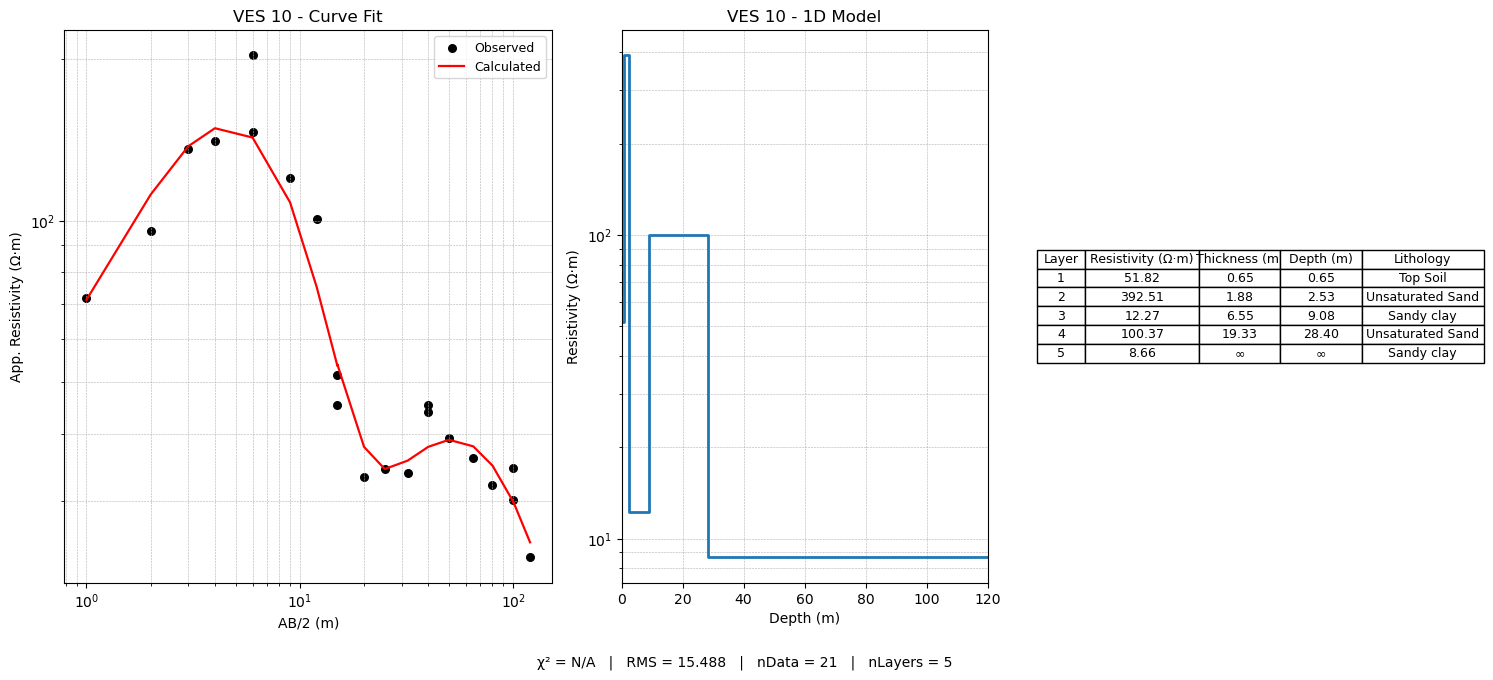

10/10/25 - 16:30:43 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:43 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:43 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


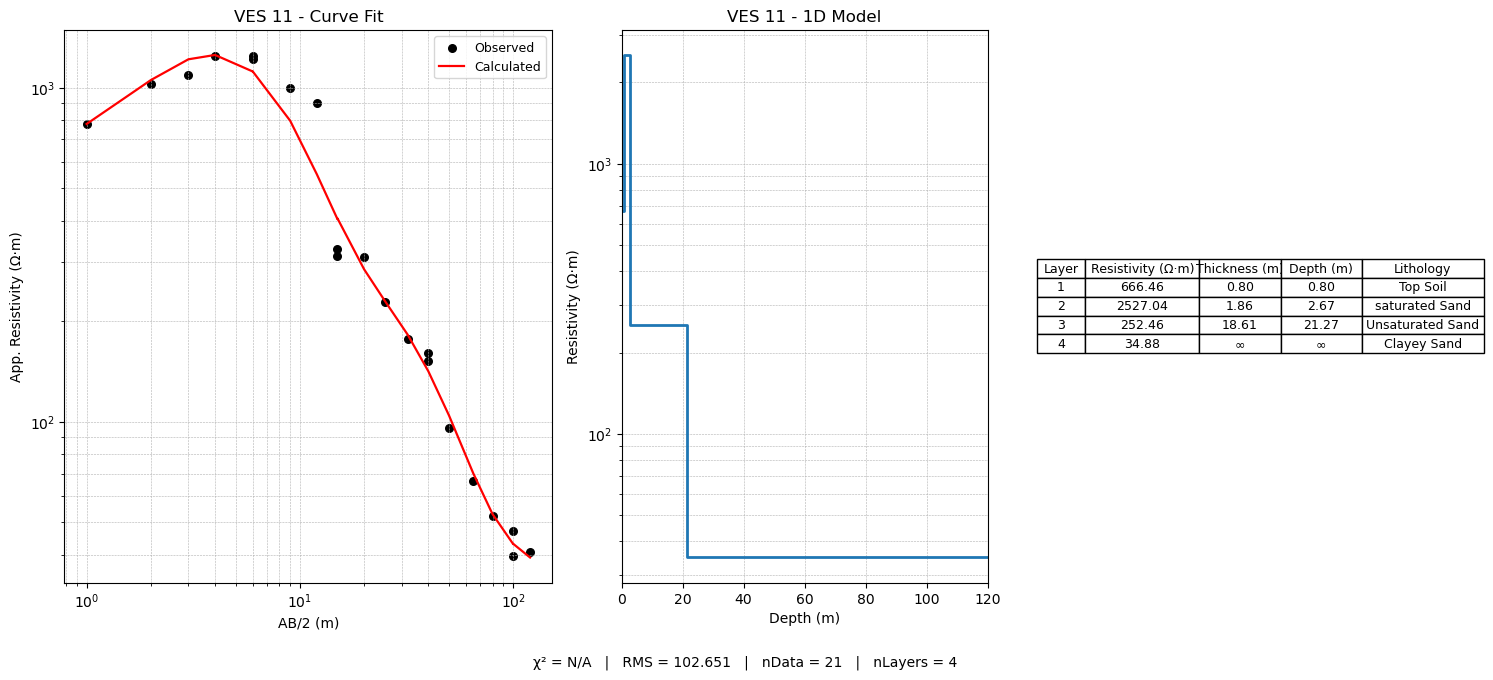

10/10/25 - 16:30:46 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:46 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:46 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


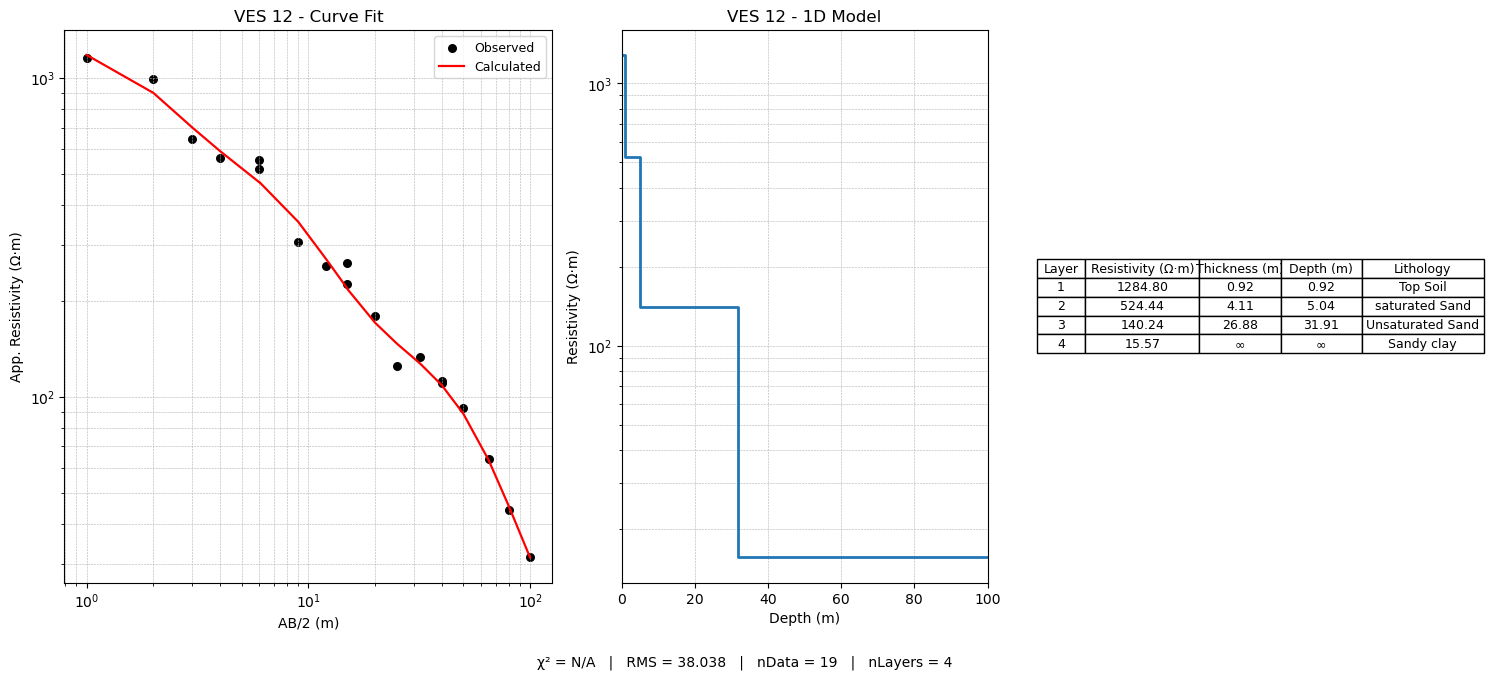

10/10/25 - 16:30:48 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:48 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:48 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:48 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:49 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:49 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:49 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


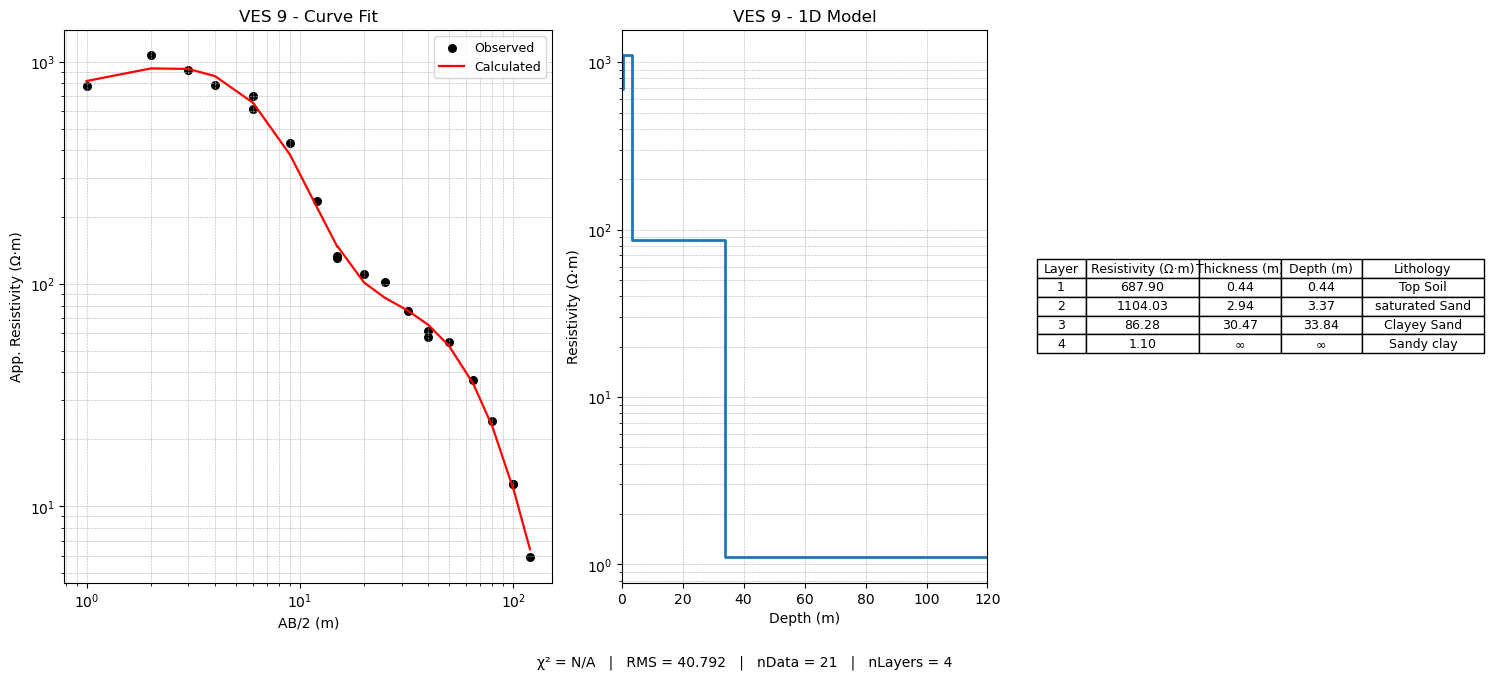

[DONE] Summary saved: C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output\summary.csv


In [10]:
"""
ves_reinv_pygimli_1.5.4  (fixed: no calls to fop.modelSize(); robust startModel sizing)

This is a drop-in replacement for your script. It forces agreement between the
start model size and the expected parameter vector size (2*nLayers - 1) and
handles 3, 4, 5 (and other) layer start models robustly.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import pygimli as pg
from pygimli.physics.ves import VESManager, VESModelling

# ---------------- CONFIG ----------------
MEASURED_XLSX = r"C:\Users\HOME\Desktop\ML Saline\VES\TR3.xlsx"
ROUGH_XLSX    = r"C:\Users\HOME\Desktop\ML Saline\VES\Pre Intrepreted depth and resistivity.xlsx"
OUT_DIR       = r"C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output"

REL_ERR       = 0.03
DEPTH_FACTOR  = 1.5
LAMBDA        = 20
SHOW_PLOTS    = True

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- HELPERS ----------------

def classify_lithology(res):
    if res < 20:   return "Sandy clay"
    if res < 100:   return "Clayey Sand"
    if res < 500:  return "Unsaturated Sand"
    if res < 3000: return "saturated Sand"
    return "Bedrock"


def fallback_thicknesses(n_layers, max_depth, ratio=2.0):
    """
    Return n_layers-1 thicknesses that approximately sum to max_depth.
    """
    if n_layers <= 1:
        return []
    n = n_layers - 1
    if n == 1:
        return [max_depth]
    denom = (ratio**n - 1) / (ratio - 1)
    t0 = max_depth / denom
    return (t0 * ratio**np.arange(n)).tolist()

def _find_col(df, keywords):
    cols = list(df.columns)
    for k in keywords:
        for c in cols:
            if k.lower() in c.lower():
                return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[0] if len(nums) > 0 else None

# ---------------- IO: ROUGH MODELS ----------------

def load_rough_models(path):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] Rough-estimates file not found: {p}  -> proceeding without roughs")
        return {}

    sheets = pd.read_excel(p, sheet_name=None)
    dfs = []
    for sname, df in sheets.items():
        df2 = df.dropna(how="all").reset_index(drop=True)
        if df2.empty:
            continue
        df2['_sheet_name_'] = str(sname)
        dfs.append(df2)
    if not dfs:
        return {}
    big = pd.concat(dfs, ignore_index=True)

    ves_col = _find_col(big, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    res_col = _find_col(big, ['resist', 'res', 'rho'])
    thk_col = _find_col(big, ['thick', 'thk', 'thickness'])

    roughs = {}
    if ves_col is not None and ves_col not in ['_sheet_name_']:
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            res = pd.to_numeric(g[res_col], errors='coerce').dropna().tolist() if res_col else []
            thk = pd.to_numeric(g[thk_col], errors='coerce').dropna().tolist() if thk_col else []
            if res:
                roughs[str(key).strip()] = {'res': res, 'thk': thk}
    else:
        for sname, df in sheets.items():
            d = df.dropna(how='all').reset_index(drop=True)
            if d.empty: continue
            rcol = _find_col(d, ['resist','res','rho'])
            tcol = _find_col(d, ['thick','thk','thickness'])
            res = pd.to_numeric(d[rcol], errors='coerce').dropna().tolist() if rcol else []
            thk = pd.to_numeric(d[tcol], errors='coerce').dropna().tolist() if tcol else []
            if res:
                roughs[str(sname).strip()] = {'res': res, 'thk': thk}

    print(f"[INFO] Loaded rough models for {len(roughs)} VES soundings from {p.name}")
    return roughs

# ---------------- MEASURED DATA LOADER ----------------

def iterate_measured_workbook(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Measured workbook not found: {p}")

    sheets = pd.read_excel(p, sheet_name=None)
    first_df = next(iter(sheets.values())).dropna(how='all').reset_index(drop=True)
    ves_col = _find_col(first_df, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    if ves_col is not None and ves_col in first_df.columns:
        dfs = [df.dropna(how='all').reset_index(drop=True) for df in sheets.values() if not df.dropna(how='all').empty]
        big = pd.concat(dfs, ignore_index=True)
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            yield str(key).strip(), g.reset_index(drop=True)
    else:
        for sname, df in sheets.items():
            yield str(sname).strip(), df.reset_index(drop=True)

# ---------------- INVERSION ----------------

def build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=None):
    """
    Ensure startModel is exactly the expected size. Expected size for nL layers
    is 2*nL - 1 (nL resistivities + nL-1 thicknesses).
    """
    target_thk_len = max(0, nL - 1)
    target_res_len = nL

    thk = list(map(float, thk0)) if thk0 is not None else []
    res = list(map(float, res0)) if res0 is not None else []

    if len(thk) < target_thk_len:
        more = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        thk = (thk + more)[:target_thk_len]

    if len(res) < target_res_len:
        last = res[-1] if len(res) > 0 else float(np.median(rhoa) if len(rhoa)>0 else 100.0)
        while len(res) < target_res_len:
            res.append(last)

    thk = thk[:target_thk_len]
    res = res[:target_res_len]

    start = np.array(list(thk) + list(res), dtype=float)

    # Do NOT rely on fop.modelSize(); compute expected size directly:
    expected_size = 2 * nL - 1
    # If fop provides a model-size-like attribute (rare), try to use it (safe guard)
    try:
        if fop is not None:
            if hasattr(fop, 'modelSize'):
                expected_size = int(fop.modelSize())
            elif hasattr(fop, 'size'):
                expected_size = int(fop.size())
    except Exception:
        expected_size = 2 * nL - 1

    # Adjust if mismatch
    if len(start) != expected_size:
        missing = expected_size - len(start)
        if missing > 0:
            # Prefer adding small thicknesses first, then resistivities
            while len(thk) < target_thk_len and len(start) < expected_size:
                thk.append(max(0.1, np.mean(thk) if len(thk)>0 else max(ab2)*0.05))
                start = np.array(list(thk) + list(res), dtype=float)
            while len(res) < target_res_len and len(start) < expected_size:
                res.append(res[-1] if len(res)>0 else (np.median(rhoa) if len(rhoa)>0 else 100.0))
                start = np.array(list(thk) + list(res), dtype=float)
        elif missing < 0:
            # truncate extras (prefer truncating extra thicknesses)
            thk = thk[:target_thk_len]
            res = res[:target_res_len]
            start = np.array(list(thk) + list(res), dtype=float)

    # final safety pad/truncate
    if len(start) != expected_size:
        if len(start) < expected_size:
            pad_val = np.median(rhoa) if len(rhoa)>0 else 100.0
            start = np.concatenate([start, np.full(expected_size - len(start), pad_val)])
        else:
            start = start[:expected_size]

    return start, thk, res

def invert_single(df, ab2_col, rhoa_col, name, roughs):
    df = df.dropna(how="all")
    if ab2_col not in df.columns or rhoa_col not in df.columns:
        return None

    df = df[(pd.to_numeric(df[ab2_col], errors='coerce')>0) & (pd.to_numeric(df[rhoa_col], errors='coerce')>0)].copy()
    if df.empty: return None

    df = df.sort_values(by=ab2_col)
    ab2 = df[ab2_col].astype(float).values
    rhoa = df[rhoa_col].astype(float).values
    mn2 = df.loc[:, df.columns.str.contains('mn2', case=False)].astype(float).values.flatten() if any(df.columns.str.contains('mn2', case=False)) else None

    rough = roughs.get(str(name).strip())
    if rough and len(rough.get('res', [])) >= 2:
        res0 = list(map(float, rough.get('res', [])))
        thk0 = list(map(float, rough.get('thk', [])))
        nL = len(res0)
        if nL < 2:
            nL = 2
        if len(thk0) < nL - 1:
            thk0 = thk0 + fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
            thk0 = thk0[:nL-1]
    else:
        nL = 4
        thk0 = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        median = np.median(rhoa) if len(rhoa)>0 else 100.0
        res0 = list(np.logspace(np.log10(max(1.0, median/3.0)), np.log10(median*3.0), nL))

    if nL < 2:
        nL = 2

    # Build a fop object for sizing check when possible (not required)
    try:
        fop_check = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
    except Exception:
        fop_check = None

    startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=fop_check)

    model = None
    used_manager = False
    try:
        fop = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
        expected = 2 * nL - 1
        # final size guarantee
        if len(startModel) != expected:
            startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop)

        inv = pg.Inversion(fop=fop, verbose=False)
        model = inv.run(rhoa, lam=LAMBDA, startModel=startModel)
        used_manager = False
    except Exception as e:
        # fallback to VESManager wrapper
        try:
            vm = VESManager()
            model = vm.invert(rhoa, ab2=ab2, mn2=mn2, startModel=startModel, err=REL_ERR, showProgress=0)
            used_manager = True
        except Exception as e2:
            # last fallback: try VESModelling without nLayers
            try:
                fop2 = VESModelling(ab2=ab2, mn2=mn2)
                startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop2)
                inv2 = pg.Inversion(fop=fop2, verbose=False)
                model = inv2.run(rhoa, lam=LAMBDA, startModel=startModel)
                used_manager = False
            except Exception as e3:
                print(f"[ERROR] Inversion failed for VES {name}. Exceptions:\n primary: {e}\n fallback1: {e2}\n fallback2: {e3}")
                return None

    model = np.asarray(model, dtype=float)

    # slice thicknesses and resistivities robustly
    if len(model) >= (nL - 1):
        thk_model = model[:max(0, nL-1)]
    else:
        thk_model = np.array([])

    if len(model) >= (len(thk_model) + nL):
        res_model = model[len(thk_model):len(thk_model)+nL]
    elif len(model) >= nL:
        res_model = model[-nL:]
    else:
        # fallback: try to consider last elements as resistivities
        res_model = model if len(model)>0 else np.array([np.median(rhoa) if len(rhoa)>0 else 100.0])

    # try compute forward response
    rho_calc = None
    try:
        if used_manager and 'vm' in locals() and hasattr(vm, 'fop') and vm.fop is not None:
            try:
                rho_calc = vm.fop.response(model)
            except Exception:
                rho_calc = None
        elif 'fop' in locals():
            try:
                rho_calc = fop.response(model)
            except Exception:
                rho_calc = None
    except Exception:
        rho_calc = None

    # depth tops
    depth_tops = np.concatenate([[0.0], np.cumsum(thk_model)]) if len(thk_model)>0 else np.array([0.0, max(ab2)])

    rows = []
    for i, r in enumerate(res_model):
        thick = float(thk_model[i]) if i < len(thk_model) else None
        depth = float(depth_tops[i+1]) if (i+1) < len(depth_tops) else (float(depth_tops[-1]) if len(depth_tops)>0 else None)
        lith = "Top Soil" if i == 0 else classify_lithology(float(r))
        rows.append({
            "layer": i+1,
            "resistivity_ohm_m": float(r),
            "thickness_m": thick,
            "depth_m": depth,
            "lithology": lith
        })

    chi2 = None; rms = None
    try:
        if used_manager and 'vm' in locals():
            if hasattr(vm, 'chi2'):
                try:
                    chi2 = vm.chi2(model)
                    rms = np.sqrt(chi2 / max(1, len(rhoa)))
                except Exception:
                    chi2 = None
            else:
                # compute residuals if possible
                if rho_calc is not None:
                    diff = (rhoa - rho_calc)
                    rms = np.sqrt(np.mean(diff**2))
                    chi2 = float('nan')
        else:
            if rho_calc is not None:
                diff = (rhoa - rho_calc)
                rms = np.sqrt(np.mean(diff**2))
                chi2 = float('nan')
    except Exception:
        pass

    return {
        "rows": rows,
        "ab2": ab2,
        "rhoa": rhoa,
        "rho_calc": rho_calc,
        "nLayers": len(res_model),
        "chi2": chi2,
        "rms": rms
    }

# ---------------- MAIN ----------------

def process(measured_xlsx, roughs_xlsx, out_dir):
    roughs = load_rough_models(roughs_xlsx) if roughs_xlsx else {}
    summary = []

    for ves_key, df in iterate_measured_workbook(measured_xlsx):
        ab2_col = _find_col(df, ['ab2','ab/2'])
        rhoa_col = _find_col(df, ['rho','rhoa','rho_a','app'])
        result = invert_single(df, ab2_col, rhoa_col, ves_key, roughs)
        if not result:
            print(f"[WARN] Skipping VES {ves_key} (inversion returned nothing).")
            continue

        out_folder = Path(out_dir) / str(ves_key)
        out_folder.mkdir(parents=True, exist_ok=True)

        df_layers = pd.DataFrame(result["rows"])
        df_layers.to_csv(out_folder / f"{ves_key}_layers.csv", index=False)

        # 3-panel plot
        fig, axes = plt.subplots(1, 3, figsize=(15,7), gridspec_kw={'width_ratios':[1.2,0.9,1]})

        # Panel 1: curve
        ax0 = axes[0]
        ax0.scatter(result["ab2"], result["rhoa"], c="k", s=30, label="Observed")
        if result["rho_calc"] is not None:
            ax0.plot(result["ab2"], result["rho_calc"], 'r-', linewidth=1.6, label="Calculated")
        ax0.set_xscale("log"); ax0.set_yscale("log")
        ax0.set_xlabel("AB/2 (m)"); ax0.set_ylabel("App. Resistivity (Ω·m)")
        ax0.set_title(f"VES {ves_key} - Curve Fit")
        ax0.legend(fontsize=9); ax0.grid(True, which="both", ls="--", lw=0.4)

        # Panel 2: depth (X) vs resistivity (Y)
        ax1 = axes[1]
        res_vals = [r['resistivity_ohm_m'] for r in result['rows']]
        thk_vals = [r['thickness_m'] for r in result['rows'] if r['thickness_m'] is not None]
        depth_tops = [0.0] + list(np.cumsum(thk_vals)) if thk_vals else [0.0]*(len(res_vals)+1)
        depths_plot = []
        rhos_plot = []
        for i, rv in enumerate(res_vals):
            top = depth_tops[i] if i < len(depth_tops) else 0.0
            bottom = depth_tops[i+1] if (i+1) < len(depth_tops) else max(result["ab2"])
            depths_plot.extend([top, bottom])
            rhos_plot.extend([rv, rv])
        if len(depths_plot) == 0:
            depths_plot = [0.0, max(result["ab2"])]
            rhos_plot = [res_vals[0] if res_vals else 100.0, res_vals[0] if res_vals else 100.0]
        ax1.semilogy(depths_plot, rhos_plot, linewidth=2)
        ax1.set_xlim(0, max(depths_plot))
        ax1.set_xlabel("Depth (m)")
        ax1.set_ylabel("Resistivity (Ω·m)")
        ax1.set_title(f"VES {ves_key} - 1D Model")
        ax1.grid(True, which="both", ls="--", lw=0.4)

        # Panel 3: table
        ax2 = axes[2]; ax2.axis('off')
        rows_table = [["Layer","Resistivity (Ω·m)","Thickness (m)","Depth (m)","Lithology"]]
        for i, r in enumerate(result['rows']):
            t = f"{r['thickness_m']:.2f}" if r['thickness_m'] is not None else "∞"
            # 👇 Force last row depth to ∞
            if i == len(result['rows']) - 1:
                d = "∞"
            else:
                d = f"{r['depth_m']:.2f}" if r['depth_m'] is not None else "∞"
            rows_table.append([r['layer'], f"{r['resistivity_ohm_m']:.2f}", t, d, r['lithology']])
        tbl = ax2.table(cellText=rows_table, cellLoc='center', loc='center', colWidths=[0.12,0.28,0.20,0.20,0.30])
        tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.1)

        # misfit annotation
        chi2 = result.get('chi2'); rms = result.get('rms')
        chi2_str = f"{chi2:.2f}" if chi2 is not None and not (isinstance(chi2,float) and np.isnan(chi2)) else "N/A"
        rms_str = f"{rms:.3f}" if rms is not None and not (isinstance(rms,float) and np.isnan(rms)) else "N/A"
        txt = f"χ² = {chi2_str}   |   RMS = {rms_str}   |   nData = {len(result['rhoa'])}   |   nLayers = {result['nLayers']}"
        fig.text(0.5, 0.01, txt, ha='center', fontsize=10)

        fig.tight_layout(rect=[0,0.04,1,0.97])
        fig.savefig(out_folder / f"{ves_key}_panel.png", dpi=200)
        if SHOW_PLOTS: plt.show()
        plt.close(fig)

        summary.append({"VES":ves_key,"nLayers":result["nLayers"],"chi2":result["chi2"],"rms":result["rms"],"out_folder":str(out_folder)})

    pd.DataFrame(summary).to_csv(Path(out_dir)/"summary.csv", index=False)
    print(f"[DONE] Summary saved: {Path(out_dir)/'summary.csv'}")

if __name__ == "__main__":
    process(MEASURED_XLSX, ROUGH_XLSX, OUT_DIR)


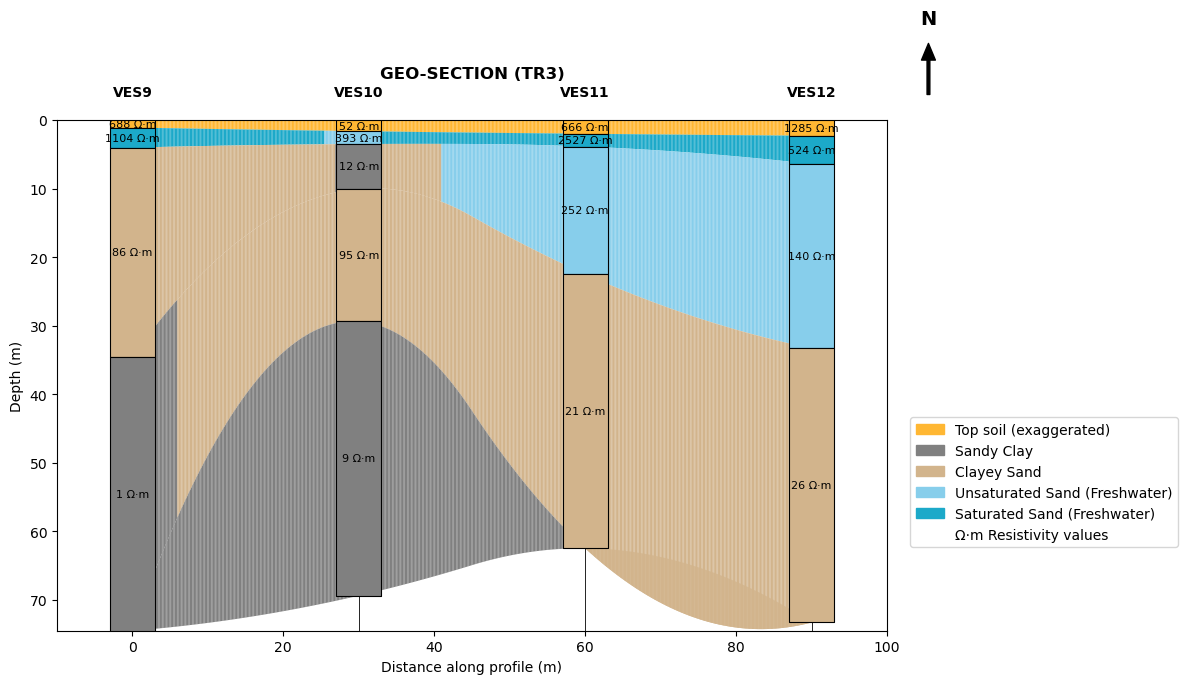

Saved to: C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS\GEO_SECTION_TR3.png


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from scipy.interpolate import make_interp_spline

# -------------------------------
# CONFIGURATION
# -------------------------------
excel_file = r"C:\Users\HOME\Desktop\ML Saline\VES\TR 3 Summary.xlsx"
ves_positions = {"VES9": 0, "VES10": 30, "VES11": 60, "VES12": 90}

profile_name = "TR3"
topsoil_exaggeration = 2.5  # visual exaggeration applied only to plotting

output_dir = r"C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------
# Lithology classification
# (returns label, color, code)
# -------------------------------
def classify_lithology(rho, is_top=False):  
    if is_top:  
        return "Topsoil", "#FFB733", -1  # yellowish-orange  
    if rho < 20:  
        return "Sandy Clay", "grey", 0  
    elif 20 <= rho < 100:  
        return "Clayey Sand", "tan", 1  
    elif 60 <= rho < 500:  
        return "Unsaturatd Sand (Freshwater)", "skyblue", 2  
    elif rho >= 500:  
        return "Saturated Sand (Freshwater)", "#1CA9C9", 3   
    else:  
        return "Resitivity Value", "black", 4    

# -------------------------------
# Read Excel file (multiple sheets)
# Each sheet must contain columns: 'resistivity' and 'thickness'
# -------------------------------
ves_data = {}
xls = pd.ExcelFile(excel_file)
for sheet in xls.sheet_names:
    df = pd.read_excel(excel_file, sheet_name=sheet)
    res = pd.to_numeric(df["resistivity"], errors="coerce").tolist()
    thk = pd.to_numeric(df["thickness"], errors="coerce").tolist()

    # Don't modify original data file — we only apply exaggeration for plotting
    thk_plot = [None if pd.isna(v) else float(v) for v in thk]
    if len(thk_plot) > 0 and thk_plot[0] is not None:
        thk_plot[0] = thk_plot[0] * topsoil_exaggeration

    key = sheet.replace(" ", "")  # normalize sheet name to match ves_positions keys
    ves_data[key] = {
        "x": ves_positions[key],
        "res": [float(r) for r in res],
        "thk": thk_plot
    }

# -------------------------------
# Build ordered lists (ensure ordering by x coordinate)
# -------------------------------
ordered_keys = sorted(ves_positions.keys(), key=lambda k: ves_positions[k])
x_coords = [ves_positions[k] for k in ordered_keys]

# build surfaces per ordered key (interfaces at each VES)
surfaces_per_ves = []
max_depth = 0
for k in ordered_keys:
    data = ves_data[k]
    depth = 0.0
    surfaces = [0.0]
    for h in data["thk"]:
        h_val = float(h) if (h is not None) else 40.0
        depth += h_val
        surfaces.append(depth)
    surfaces_per_ves.append(surfaces)
    max_depth = max(max_depth, depth)

# pad surfaces so same length
max_ifaces = max(len(s) for s in surfaces_per_ves)
for s in surfaces_per_ves:
    while len(s) < max_ifaces:
        s.append(s[-1])

# transpose -> each interface across VES
interfaces = list(map(list, zip(*surfaces_per_ves)))  # len = max_ifaces

# -------------------------------
# Prepare smooth interfaces (interpolate horizontally)
# -------------------------------
xs_dense = np.linspace(min(x_coords), max(x_coords), 500)

smooth_ifaces = []
for iface in interfaces:
    # iface is list of depths at the ordered VES positions
    spline = make_interp_spline(x_coords, iface, k=2)
    smooth_ifaces.append(spline(xs_dense))

# -------------------------------
# Prepare per-layer resistivity profiles interpolated horizontally
# (for each layer j we compute resistivity along xs_dense)
# -------------------------------
n_layers = len(smooth_ifaces) - 1
resistivity_profiles = []  # each entry length = len(xs_dense)
for layer_idx in range(n_layers):
    # gather resistivities at each VES for this layer
    res_at_ves = []
    for k in ordered_keys:
        res_list = ves_data[k]["res"]
        if layer_idx < len(res_list):
            res_at_ves.append(res_list[layer_idx])
        else:
            # use last available resistivity if layer missing
            res_at_ves.append(res_list[-1])
    # linear interpolation across x_coords -> xs_dense
    res_profile = np.interp(xs_dense, x_coords, res_at_ves)
    resistivity_profiles.append(res_profile)

# -------------------------------
# Plot: fill background with many thin trapezoids so horizontal color follows per-layer resistivity
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 7))

# For each layer, iterate along xs_dense segments and draw small trapezoids colored by local resistivity
for j in range(n_layers):
    iface_top = smooth_ifaces[j]
    iface_bot = smooth_ifaces[j + 1]
    res_profile = resistivity_profiles[j]

    # loop over segments
    for k in range(len(xs_dense) - 1):
        x0, x1 = xs_dense[k], xs_dense[k + 1]
        # y coordinates for trapezoid corners
        y0_top, y1_top = iface_top[k], iface_top[k + 1]
        y0_bot, y1_bot = iface_bot[k], iface_bot[k + 1]

        # mean resistivity for this small segment
        rmean = 0.5 * (res_profile[k] + res_profile[k + 1])
        _, color, _ = classify_lithology(rmean, is_top=(j == 0))

        # draw the small trapezoid
        xs_seg = [x0, x1, x1, x0]
        ys_seg = [y0_top, y1_top, y1_bot, y0_bot]
        ax.fill(xs_seg, ys_seg, color=color, edgecolor="none", linewidth=0)

# Overlay VES bars (solid, sharp) on top to ensure perfect match
bar_half = 3.0  # half width of each VES bar
for k in ordered_keys:
    x = ves_positions[k]
    depth = 0.0
    data = ves_data[k]
    for idx, rho in enumerate(data["res"]):
        h = data["thk"][idx] if idx < len(data["thk"]) else None
        h_val = float(h) if (h is not None) else 40.0
        bottom = depth + h_val
        lith, color, _ = classify_lithology(rho, is_top=(idx == 0))
        # draw bar with black edge to match desired look
        ax.fill_between([x - bar_half, x + bar_half], depth, bottom, color=color,
                        edgecolor="k", linewidth=0.8, zorder=5)
        # annotate resistivity
        ax.text(x, (depth + bottom) / 2, f"{rho:.0f} Ω·m", ha="center", va="center", fontsize=8, zorder=6)
        depth = bottom
    # station label
    ax.text(x, -3, k, ha="center", va="bottom", fontsize=10, fontweight="bold", zorder=7)

# vertical separators at each VES (optional, looks like your desired figure)
for x in x_coords:
    ax.vlines(x, 0, max_depth, colors="k", linewidth=0.6, linestyles='solid', zorder=4)

# -------------------------------  
# Axis labels & title  
# -------------------------------  
ax.set_xlabel("Distance along profile (m)")  
ax.set_ylabel("Depth (m)")  
ax.set_title(f"GEO-SECTION ({profile_name})", pad=30, fontweight="bold")  

ax.set_ylim(max_depth, 0)  
ax.set_xlim(min(x_coords)-10, max(x_coords)+10) 


# Arrow pointing up with "N" at the top
ax.annotate('', 
            xy=(1.05, 1.15),  # arrow head (top)
            xytext=(1.05, 1.05),  # arrow tail (bottom)
            xycoords='axes fraction',
            arrowprops=dict(facecolor='black', width=2, headwidth=10))

# "N" label above the arrow
ax.text(1.05, 1.18, 'N', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=14, fontweight='bold')


# Legend (placed outside to the right, below the north arrow)
legend_patches = [
    mpatches.Patch(color="#FFB733", label="Top soil (exaggerated)"),
    mpatches.Patch(color="grey", label="Sandy Clay"),
    mpatches.Patch(color="tan", label="Clayey Sand"),
    mpatches.Patch(color="skyblue", label="Unsaturated Sand (Freshwater)"),
    mpatches.Patch(color="#1CA9C9", label="Saturated Sand (Freshwater)"),
    mpatches.Patch(facecolor="white", edgecolor="none", label="Ω·m Resistivity values")
]
ax.legend(handles=legend_patches, loc="lower left", bbox_to_anchor=(1.02, 0.15), frameon=True)

plt.tight_layout()

# save and show
output_path = os.path.join(output_dir, f"GEO_SECTION_{profile_name}.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", output_path)


#### TRAVERSE 4

10/10/25 - 16:30:58 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:58 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:30:58 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


[INFO] Loaded rough models for 20 VES soundings from Pre Intrepreted depth and resistivity.xlsx


10/10/25 - 16:30:58 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


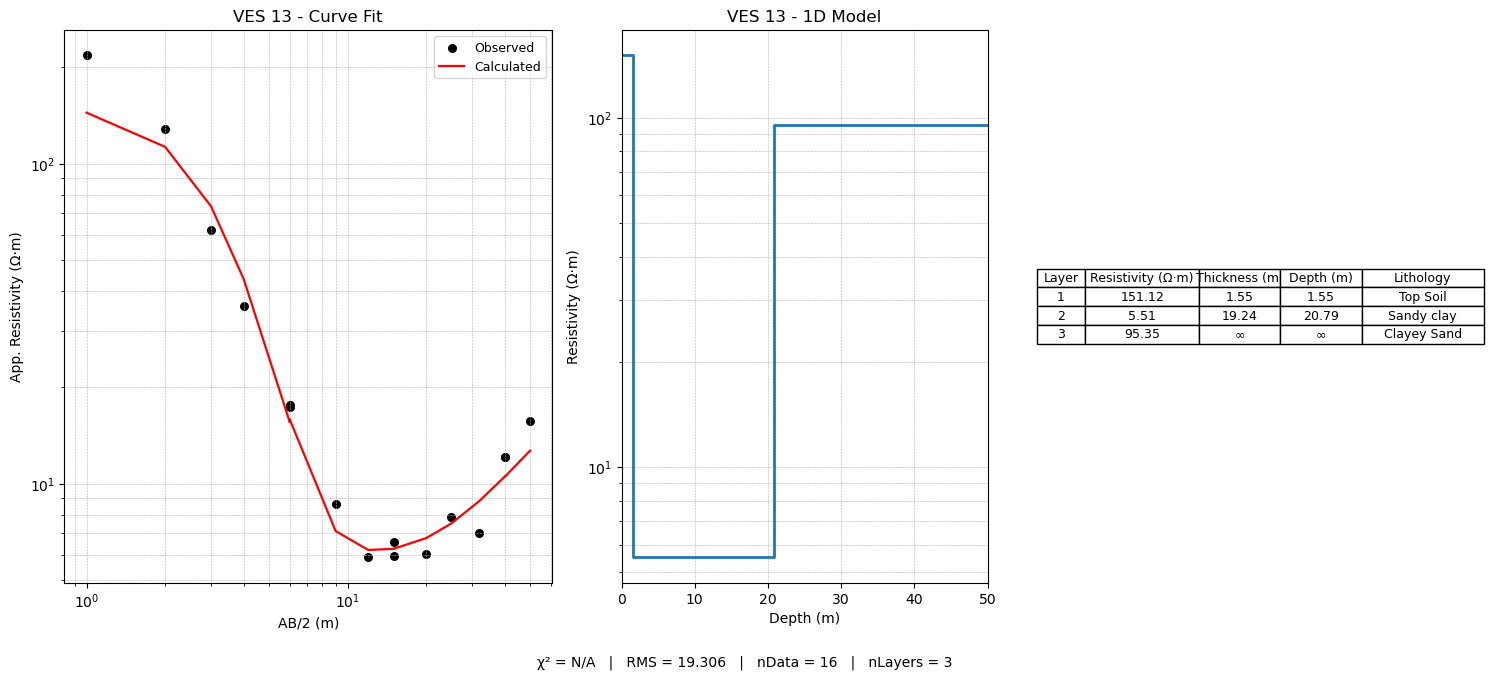

10/10/25 - 16:31:00 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:00 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:00 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


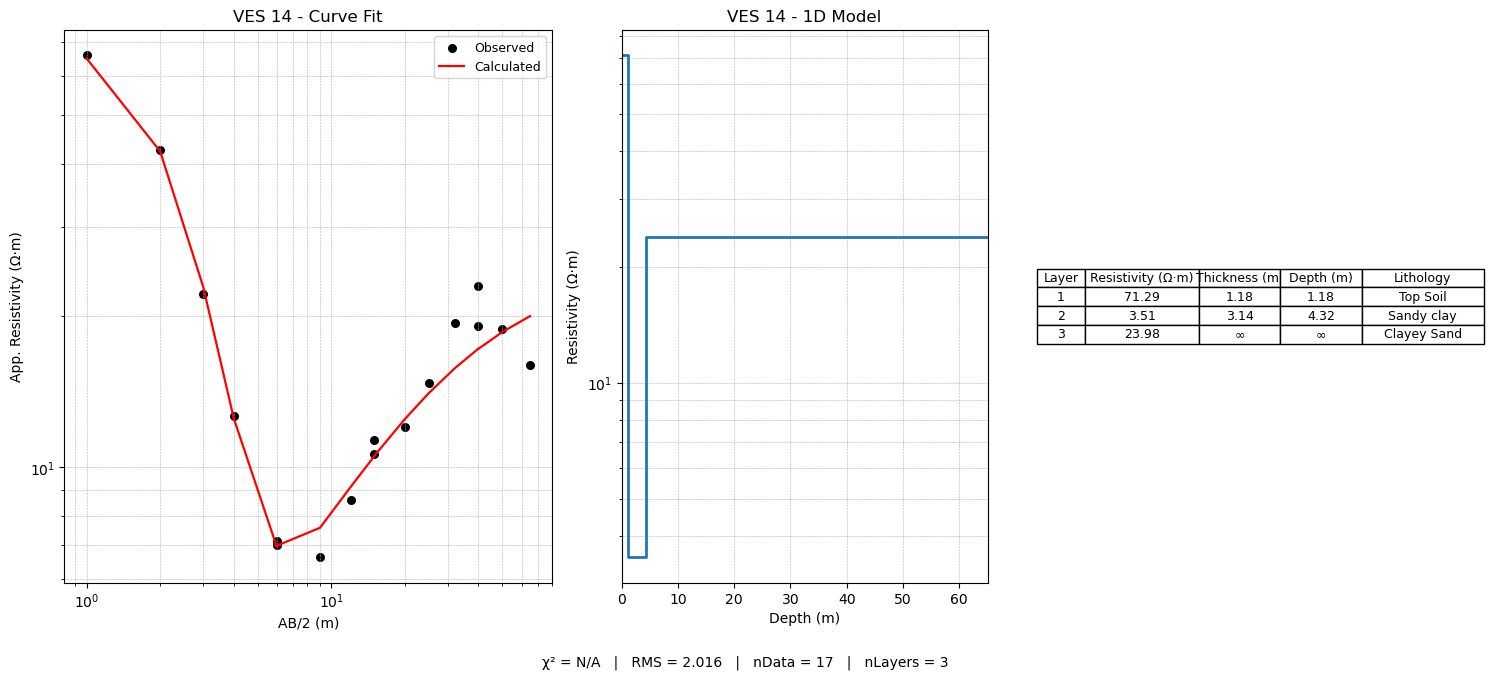

10/10/25 - 16:31:02 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:02 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:02 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:02 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


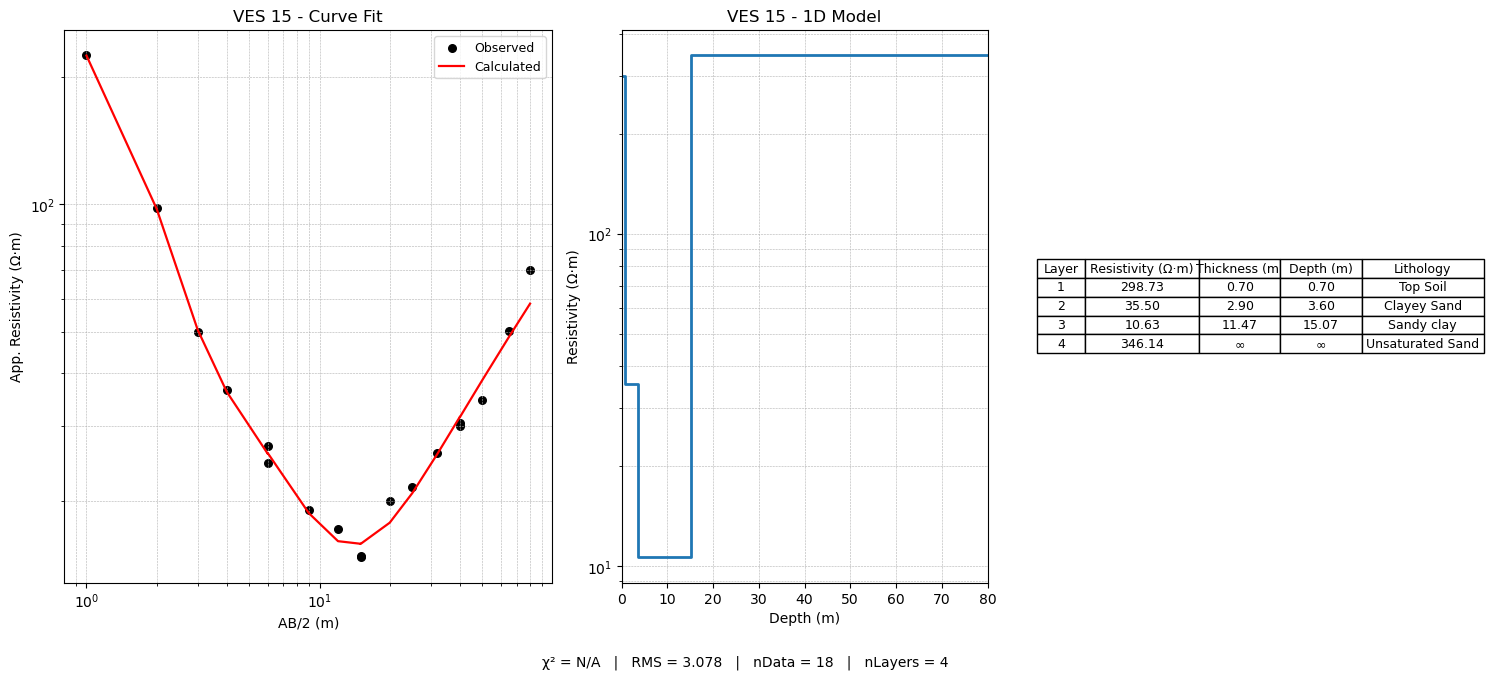

10/10/25 - 16:31:05 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:05 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:05 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:05 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


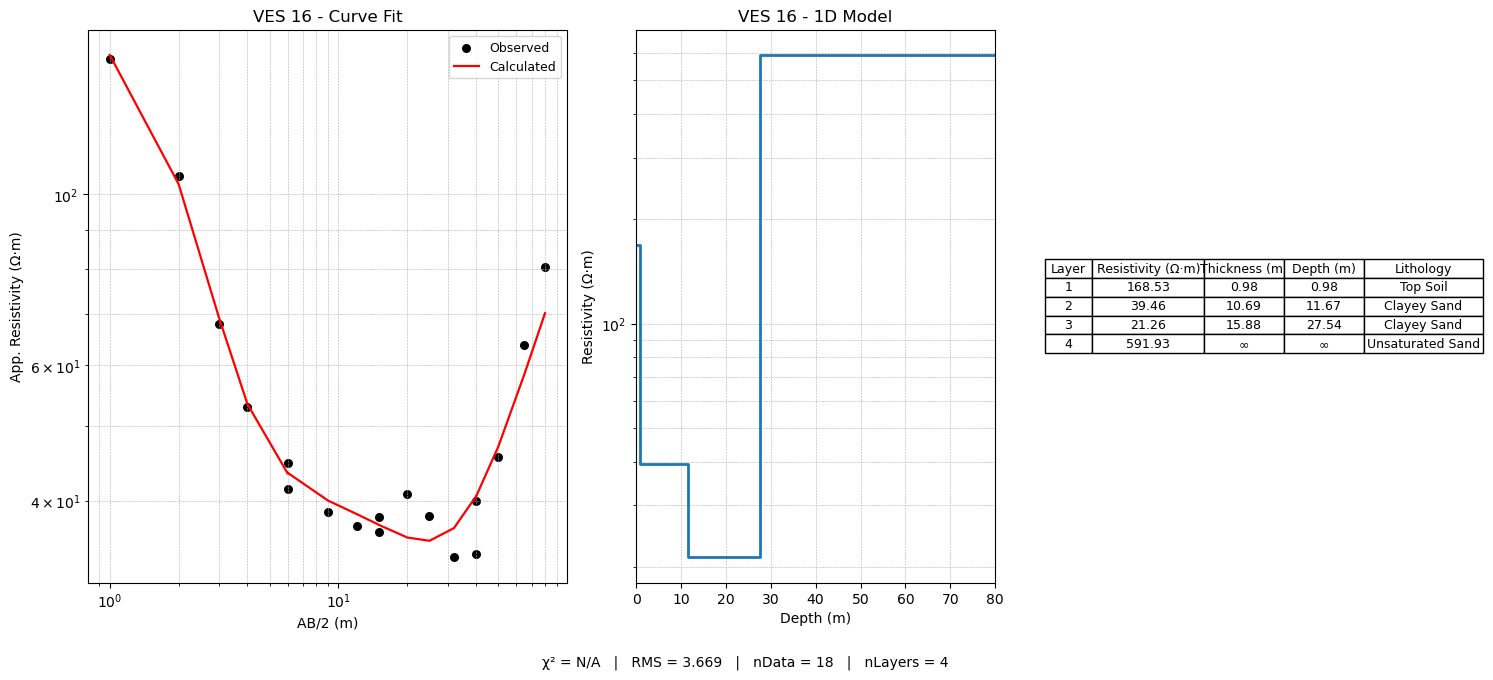

[DONE] Summary saved: C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output\summary.csv


In [12]:
"""
ves_reinv_pygimli_1.5.4  (fixed: no calls to fop.modelSize(); robust startModel sizing)

This is a drop-in replacement for your script. It forces agreement between the
start model size and the expected parameter vector size (2*nLayers - 1) and
handles 3, 4, 5 (and other) layer start models robustly.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import pygimli as pg
from pygimli.physics.ves import VESManager, VESModelling

# ---------------- CONFIG ----------------
MEASURED_XLSX = r"C:\Users\HOME\Desktop\ML Saline\VES\TR4.xlsx"
ROUGH_XLSX    = r"C:\Users\HOME\Desktop\ML Saline\VES\Pre Intrepreted depth and resistivity.xlsx"
OUT_DIR       = r"C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output"

REL_ERR       = 0.03
DEPTH_FACTOR  = 1.5
LAMBDA        = 20
SHOW_PLOTS    = True

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- HELPERS ----------------

def classify_lithology(res):
    if res < 20:   return "Sandy clay"
    if res < 100:   return "Clayey Sand"
    if res < 600:  return "Unsaturated Sand"
    if res < 3000: return "Saturated Sand"
    return "Bedrock"


def fallback_thicknesses(n_layers, max_depth, ratio=2.0):
    """
    Return n_layers-1 thicknesses that approximately sum to max_depth.
    """
    if n_layers <= 1:
        return []
    n = n_layers - 1
    if n == 1:
        return [max_depth]
    denom = (ratio**n - 1) / (ratio - 1)
    t0 = max_depth / denom
    return (t0 * ratio**np.arange(n)).tolist()

def _find_col(df, keywords):
    cols = list(df.columns)
    for k in keywords:
        for c in cols:
            if k.lower() in c.lower():
                return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[0] if len(nums) > 0 else None

# ---------------- IO: ROUGH MODELS ----------------

def load_rough_models(path):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] Rough-estimates file not found: {p}  -> proceeding without roughs")
        return {}

    sheets = pd.read_excel(p, sheet_name=None)
    dfs = []
    for sname, df in sheets.items():
        df2 = df.dropna(how="all").reset_index(drop=True)
        if df2.empty:
            continue
        df2['_sheet_name_'] = str(sname)
        dfs.append(df2)
    if not dfs:
        return {}
    big = pd.concat(dfs, ignore_index=True)

    ves_col = _find_col(big, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    res_col = _find_col(big, ['resist', 'res', 'rho'])
    thk_col = _find_col(big, ['thick', 'thk', 'thickness'])

    roughs = {}
    if ves_col is not None and ves_col not in ['_sheet_name_']:
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            res = pd.to_numeric(g[res_col], errors='coerce').dropna().tolist() if res_col else []
            thk = pd.to_numeric(g[thk_col], errors='coerce').dropna().tolist() if thk_col else []
            if res:
                roughs[str(key).strip()] = {'res': res, 'thk': thk}
    else:
        for sname, df in sheets.items():
            d = df.dropna(how='all').reset_index(drop=True)
            if d.empty: continue
            rcol = _find_col(d, ['resist','res','rho'])
            tcol = _find_col(d, ['thick','thk','thickness'])
            res = pd.to_numeric(d[rcol], errors='coerce').dropna().tolist() if rcol else []
            thk = pd.to_numeric(d[tcol], errors='coerce').dropna().tolist() if tcol else []
            if res:
                roughs[str(sname).strip()] = {'res': res, 'thk': thk}

    print(f"[INFO] Loaded rough models for {len(roughs)} VES soundings from {p.name}")
    return roughs

# ---------------- MEASURED DATA LOADER ----------------

def iterate_measured_workbook(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Measured workbook not found: {p}")

    sheets = pd.read_excel(p, sheet_name=None)
    first_df = next(iter(sheets.values())).dropna(how='all').reset_index(drop=True)
    ves_col = _find_col(first_df, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    if ves_col is not None and ves_col in first_df.columns:
        dfs = [df.dropna(how='all').reset_index(drop=True) for df in sheets.values() if not df.dropna(how='all').empty]
        big = pd.concat(dfs, ignore_index=True)
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            yield str(key).strip(), g.reset_index(drop=True)
    else:
        for sname, df in sheets.items():
            yield str(sname).strip(), df.reset_index(drop=True)

# ---------------- INVERSION ----------------

def build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=None):
    """
    Ensure startModel is exactly the expected size. Expected size for nL layers
    is 2*nL - 1 (nL resistivities + nL-1 thicknesses).
    """
    target_thk_len = max(0, nL - 1)
    target_res_len = nL

    thk = list(map(float, thk0)) if thk0 is not None else []
    res = list(map(float, res0)) if res0 is not None else []

    if len(thk) < target_thk_len:
        more = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        thk = (thk + more)[:target_thk_len]

    if len(res) < target_res_len:
        last = res[-1] if len(res) > 0 else float(np.median(rhoa) if len(rhoa)>0 else 100.0)
        while len(res) < target_res_len:
            res.append(last)

    thk = thk[:target_thk_len]
    res = res[:target_res_len]

    start = np.array(list(thk) + list(res), dtype=float)

    # Do NOT rely on fop.modelSize(); compute expected size directly:
    expected_size = 2 * nL - 1
    # If fop provides a model-size-like attribute (rare), try to use it (safe guard)
    try:
        if fop is not None:
            if hasattr(fop, 'modelSize'):
                expected_size = int(fop.modelSize())
            elif hasattr(fop, 'size'):
                expected_size = int(fop.size())
    except Exception:
        expected_size = 2 * nL - 1

    # Adjust if mismatch
    if len(start) != expected_size:
        missing = expected_size - len(start)
        if missing > 0:
            # Prefer adding small thicknesses first, then resistivities
            while len(thk) < target_thk_len and len(start) < expected_size:
                thk.append(max(0.1, np.mean(thk) if len(thk)>0 else max(ab2)*0.05))
                start = np.array(list(thk) + list(res), dtype=float)
            while len(res) < target_res_len and len(start) < expected_size:
                res.append(res[-1] if len(res)>0 else (np.median(rhoa) if len(rhoa)>0 else 100.0))
                start = np.array(list(thk) + list(res), dtype=float)
        elif missing < 0:
            # truncate extras (prefer truncating extra thicknesses)
            thk = thk[:target_thk_len]
            res = res[:target_res_len]
            start = np.array(list(thk) + list(res), dtype=float)

    # final safety pad/truncate
    if len(start) != expected_size:
        if len(start) < expected_size:
            pad_val = np.median(rhoa) if len(rhoa)>0 else 100.0
            start = np.concatenate([start, np.full(expected_size - len(start), pad_val)])
        else:
            start = start[:expected_size]

    return start, thk, res

def invert_single(df, ab2_col, rhoa_col, name, roughs):
    df = df.dropna(how="all")
    if ab2_col not in df.columns or rhoa_col not in df.columns:
        return None

    df = df[(pd.to_numeric(df[ab2_col], errors='coerce')>0) & (pd.to_numeric(df[rhoa_col], errors='coerce')>0)].copy()
    if df.empty: return None

    df = df.sort_values(by=ab2_col)
    ab2 = df[ab2_col].astype(float).values
    rhoa = df[rhoa_col].astype(float).values
    mn2 = df.loc[:, df.columns.str.contains('mn2', case=False)].astype(float).values.flatten() if any(df.columns.str.contains('mn2', case=False)) else None

    rough = roughs.get(str(name).strip())
    if rough and len(rough.get('res', [])) >= 2:
        res0 = list(map(float, rough.get('res', [])))
        thk0 = list(map(float, rough.get('thk', [])))
        nL = len(res0)
        if nL < 2:
            nL = 2
        if len(thk0) < nL - 1:
            thk0 = thk0 + fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
            thk0 = thk0[:nL-1]
    else:
        nL = 4
        thk0 = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        median = np.median(rhoa) if len(rhoa)>0 else 100.0
        res0 = list(np.logspace(np.log10(max(1.0, median/3.0)), np.log10(median*3.0), nL))

    if nL < 2:
        nL = 2

    # Build a fop object for sizing check when possible (not required)
    try:
        fop_check = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
    except Exception:
        fop_check = None

    startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=fop_check)

    model = None
    used_manager = False
    try:
        fop = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
        expected = 2 * nL - 1
        # final size guarantee
        if len(startModel) != expected:
            startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop)

        inv = pg.Inversion(fop=fop, verbose=False)
        model = inv.run(rhoa, lam=LAMBDA, startModel=startModel)
        used_manager = False
    except Exception as e:
        # fallback to VESManager wrapper
        try:
            vm = VESManager()
            model = vm.invert(rhoa, ab2=ab2, mn2=mn2, startModel=startModel, err=REL_ERR, showProgress=0)
            used_manager = True
        except Exception as e2:
            # last fallback: try VESModelling without nLayers
            try:
                fop2 = VESModelling(ab2=ab2, mn2=mn2)
                startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop2)
                inv2 = pg.Inversion(fop=fop2, verbose=False)
                model = inv2.run(rhoa, lam=LAMBDA, startModel=startModel)
                used_manager = False
            except Exception as e3:
                print(f"[ERROR] Inversion failed for VES {name}. Exceptions:\n primary: {e}\n fallback1: {e2}\n fallback2: {e3}")
                return None

    model = np.asarray(model, dtype=float)

    # slice thicknesses and resistivities robustly
    if len(model) >= (nL - 1):
        thk_model = model[:max(0, nL-1)]
    else:
        thk_model = np.array([])

    if len(model) >= (len(thk_model) + nL):
        res_model = model[len(thk_model):len(thk_model)+nL]
    elif len(model) >= nL:
        res_model = model[-nL:]
    else:
        # fallback: try to consider last elements as resistivities
        res_model = model if len(model)>0 else np.array([np.median(rhoa) if len(rhoa)>0 else 100.0])

    # try compute forward response
    rho_calc = None
    try:
        if used_manager and 'vm' in locals() and hasattr(vm, 'fop') and vm.fop is not None:
            try:
                rho_calc = vm.fop.response(model)
            except Exception:
                rho_calc = None
        elif 'fop' in locals():
            try:
                rho_calc = fop.response(model)
            except Exception:
                rho_calc = None
    except Exception:
        rho_calc = None

    # depth tops
    depth_tops = np.concatenate([[0.0], np.cumsum(thk_model)]) if len(thk_model)>0 else np.array([0.0, max(ab2)])

    rows = []
    for i, r in enumerate(res_model):
        thick = float(thk_model[i]) if i < len(thk_model) else None
        depth = float(depth_tops[i+1]) if (i+1) < len(depth_tops) else (float(depth_tops[-1]) if len(depth_tops)>0 else None)
        lith = "Top Soil" if i == 0 else classify_lithology(float(r))
        rows.append({
            "layer": i+1,
            "resistivity_ohm_m": float(r),
            "thickness_m": thick,
            "depth_m": depth,
            "lithology": lith
        })

    chi2 = None; rms = None
    try:
        if used_manager and 'vm' in locals():
            if hasattr(vm, 'chi2'):
                try:
                    chi2 = vm.chi2(model)
                    rms = np.sqrt(chi2 / max(1, len(rhoa)))
                except Exception:
                    chi2 = None
            else:
                # compute residuals if possible
                if rho_calc is not None:
                    diff = (rhoa - rho_calc)
                    rms = np.sqrt(np.mean(diff**2))
                    chi2 = float('nan')
        else:
            if rho_calc is not None:
                diff = (rhoa - rho_calc)
                rms = np.sqrt(np.mean(diff**2))
                chi2 = float('nan')
    except Exception:
        pass

    return {
        "rows": rows,
        "ab2": ab2,
        "rhoa": rhoa,
        "rho_calc": rho_calc,
        "nLayers": len(res_model),
        "chi2": chi2,
        "rms": rms
    }

# ---------------- MAIN ----------------

def process(measured_xlsx, roughs_xlsx, out_dir):
    roughs = load_rough_models(roughs_xlsx) if roughs_xlsx else {}
    summary = []

    for ves_key, df in iterate_measured_workbook(measured_xlsx):
        ab2_col = _find_col(df, ['ab2','ab/2'])
        rhoa_col = _find_col(df, ['rho','rhoa','rho_a','app'])
        result = invert_single(df, ab2_col, rhoa_col, ves_key, roughs)
        if not result:
            print(f"[WARN] Skipping VES {ves_key} (inversion returned nothing).")
            continue

        out_folder = Path(out_dir) / str(ves_key)
        out_folder.mkdir(parents=True, exist_ok=True)

        df_layers = pd.DataFrame(result["rows"])
        df_layers.to_csv(out_folder / f"{ves_key}_layers.csv", index=False)

        # 3-panel plot
        fig, axes = plt.subplots(1, 3, figsize=(15,7), gridspec_kw={'width_ratios':[1.2,0.9,1]})

        # Panel 1: curve
        ax0 = axes[0]
        ax0.scatter(result["ab2"], result["rhoa"], c="k", s=30, label="Observed")
        if result["rho_calc"] is not None:
            ax0.plot(result["ab2"], result["rho_calc"], 'r-', linewidth=1.6, label="Calculated")
        ax0.set_xscale("log"); ax0.set_yscale("log")
        ax0.set_xlabel("AB/2 (m)"); ax0.set_ylabel("App. Resistivity (Ω·m)")
        ax0.set_title(f"VES {ves_key} - Curve Fit")
        ax0.legend(fontsize=9); ax0.grid(True, which="both", ls="--", lw=0.4)

        # Panel 2: depth (X) vs resistivity (Y)
        ax1 = axes[1]
        res_vals = [r['resistivity_ohm_m'] for r in result['rows']]
        thk_vals = [r['thickness_m'] for r in result['rows'] if r['thickness_m'] is not None]
        depth_tops = [0.0] + list(np.cumsum(thk_vals)) if thk_vals else [0.0]*(len(res_vals)+1)
        depths_plot = []
        rhos_plot = []
        for i, rv in enumerate(res_vals):
            top = depth_tops[i] if i < len(depth_tops) else 0.0
            bottom = depth_tops[i+1] if (i+1) < len(depth_tops) else max(result["ab2"])
            depths_plot.extend([top, bottom])
            rhos_plot.extend([rv, rv])
        if len(depths_plot) == 0:
            depths_plot = [0.0, max(result["ab2"])]
            rhos_plot = [res_vals[0] if res_vals else 100.0, res_vals[0] if res_vals else 100.0]
        ax1.semilogy(depths_plot, rhos_plot, linewidth=2)
        ax1.set_xlim(0, max(depths_plot))
        ax1.set_xlabel("Depth (m)")
        ax1.set_ylabel("Resistivity (Ω·m)")
        ax1.set_title(f"VES {ves_key} - 1D Model")
        ax1.grid(True, which="both", ls="--", lw=0.4)

        # Panel 3: table
        ax2 = axes[2]; ax2.axis('off')
        rows_table = [["Layer","Resistivity (Ω·m)","Thickness (m)","Depth (m)","Lithology"]]
        for i, r in enumerate(result['rows']):
            t = f"{r['thickness_m']:.2f}" if r['thickness_m'] is not None else "∞"
            # 👇 Force last row depth to ∞
            if i == len(result['rows']) - 1:
                d = "∞"
            else:
                d = f"{r['depth_m']:.2f}" if r['depth_m'] is not None else "∞"
            rows_table.append([r['layer'], f"{r['resistivity_ohm_m']:.2f}", t, d, r['lithology']])
        tbl = ax2.table(cellText=rows_table, cellLoc='center', loc='center', colWidths=[0.12,0.28,0.20,0.20,0.30])
        tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.1)

        # misfit annotation
        chi2 = result.get('chi2'); rms = result.get('rms')
        chi2_str = f"{chi2:.2f}" if chi2 is not None and not (isinstance(chi2,float) and np.isnan(chi2)) else "N/A"
        rms_str = f"{rms:.3f}" if rms is not None and not (isinstance(rms,float) and np.isnan(rms)) else "N/A"
        txt = f"χ² = {chi2_str}   |   RMS = {rms_str}   |   nData = {len(result['rhoa'])}   |   nLayers = {result['nLayers']}"
        fig.text(0.5, 0.01, txt, ha='center', fontsize=10)

        fig.tight_layout(rect=[0,0.04,1,0.97])
        fig.savefig(out_folder / f"{ves_key}_panel.png", dpi=200)
        if SHOW_PLOTS: plt.show()
        plt.close(fig)

        summary.append({"VES":ves_key,"nLayers":result["nLayers"],"chi2":result["chi2"],"rms":result["rms"],"out_folder":str(out_folder)})

    pd.DataFrame(summary).to_csv(Path(out_dir)/"summary.csv", index=False)
    print(f"[DONE] Summary saved: {Path(out_dir)/'summary.csv'}")

if __name__ == "__main__":
    process(MEASURED_XLSX, ROUGH_XLSX, OUT_DIR)


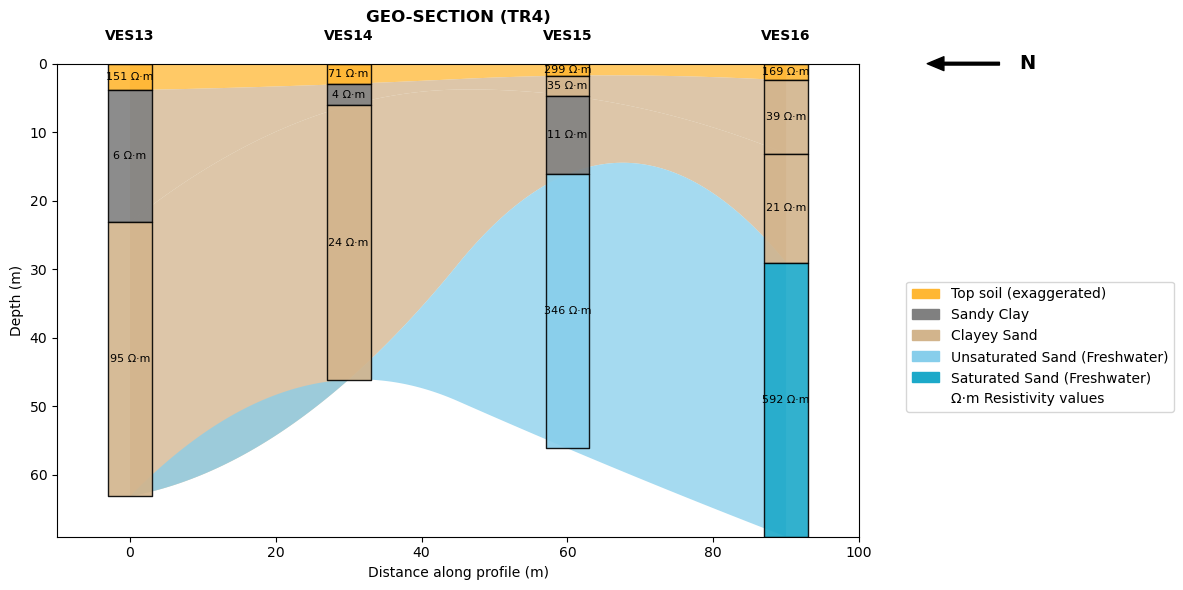

Figure saved at: C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS\GEO_SECTION_TR4.png


In [13]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
import matplotlib.patches as mpatches  
from scipy.interpolate import make_interp_spline  
import os  

# -------------------------------
# CONFIGURATION
# -------------------------------
excel_file = r"C:\Users\HOME\Desktop\ML Saline\VES\TR 4 Summary.xlsx"
ves_positions = {"VES13": 0, "VES14": 30, "VES15": 60, "VES16": 90}

profile_name = "TR4" 
topsoil_exaggeration = 2.5  # exaggerate topsoil thickness ×1.5  

# -------------------------------  
# Lithology classification  
# -------------------------------  
def classify_lithology(rho, is_top=False):  
    if is_top:  
        return "Topsoil", "#FFB733", -1  # yellowish-orange  
    if rho < 20:  
        return "Sandy Clay", "grey", 0  
    elif 20 <= rho < 100:  
        return "Clayey Sand", "tan", 1  
    elif 60 <= rho < 500:  
        return "Unsaturatd Sand (Freshwater)", "skyblue", 2  
    elif rho >= 500:  
        return "Saturated Sand (Freshwater)", "#1CA9C9", 3   
    else:  
        return "Resitivity Value", "black", 4    

# -------------------------------  
# Read Excel file (multiple sheets)  
# -------------------------------  
ves_data = {}  
xls = pd.ExcelFile(excel_file)  

for sheet in xls.sheet_names:  
    df = pd.read_excel(excel_file, sheet_name=sheet)  
    res = pd.to_numeric(df["resistivity"], errors="coerce").tolist()  
    thk = pd.to_numeric(df["thickness"], errors="coerce").tolist()  

    # exaggerate topsoil thickness (only first layer)  
    if thk and not pd.isna(thk[0]):  
        thk[0] *= topsoil_exaggeration  

    key = sheet.replace(" ", "")  # normalize  
    ves_data[key] = {  
        "x": ves_positions[key],  
        "res": res,  
        "thk": [None if pd.isna(v) else v for v in thk]  
    }  

# -------------------------------  
# Step 1: Extract layer interfaces across all VES  
# -------------------------------  
layer_surfaces = []  
max_depth = 0  

for ves, data in ves_data.items():  
    depth = 0  
    surfaces = [0]  # start at ground surface  
    for h in data["thk"]:  
        h_val = h if h else 40  
        depth += h_val  
        surfaces.append(depth)  
    layer_surfaces.append(surfaces)  
    max_depth = max(max_depth, depth)  

# pad so all VES have same number of interfaces  
max_layers = max(len(s) for s in layer_surfaces)  
for s in layer_surfaces:  
    while len(s) < max_layers:  
        s.append(s[-1])  

layer_surfaces = list(map(list, zip(*layer_surfaces)))  # transpose  

# -------------------------------  
# Step 2: Smooth interpolate each interface  
# -------------------------------  
x_coords = list(ves_positions.values())  
xs_dense = np.linspace(min(x_coords), max(x_coords), 400)  

smooth_surfaces = []  
for surface in layer_surfaces:  
    spline = make_interp_spline(x_coords, surface, k=2)  
    smooth_surfaces.append(spline(xs_dense))  

# -------------------------------  
# Step 3: Average resistivities per layer (for colors)  
# -------------------------------  
layer_avg_rho = []  
for i in range(len(layer_surfaces) - 1):  
    vals = []  
    for ves, data in ves_data.items():  
        if i < len(data["res"]):  
            vals.append(data["res"][i])  
    layer_avg_rho.append(np.nanmean(vals) if vals else 50)  

# -------------------------------  
# Step 4: Plot smooth filled layers + VES bars  
# -------------------------------  
fig, ax = plt.subplots(figsize=(12, 6))  

for i in range(len(smooth_surfaces) - 1):  
    rho = layer_avg_rho[i]  
    is_top = (i == 0)  
    lith, color, _ = classify_lithology(rho, is_top=is_top)  

    ax.fill_between(xs_dense,  
                    smooth_surfaces[i],  
                    smooth_surfaces[i+1],  
                    color=color, edgecolor="none", alpha=0.75)  

# Overlay VES bars  
for ves, data in ves_data.items():  
    x = data["x"]  
    depth = 0  
    for i, rho in enumerate(data["res"]):  
        h = data["thk"][i] if data["thk"][i] else 40  
        bottom = depth + h  
        is_top = (i == 0)  
        lith, color, _ = classify_lithology(rho, is_top=is_top)  
        ax.fill_between([x-3, x+3], depth, bottom, color=color, edgecolor="k", alpha=0.9)  
        ax.text(x, (depth+bottom)/2, f"{rho:.0f} Ω·m", ha="center", va="center", fontsize=8)  
        depth = bottom  
    ax.text(x, -3, ves, ha="center", va="bottom", fontsize=10, fontweight="bold")  

# -------------------------------  
# Axis labels & title  
# -------------------------------  
ax.set_xlabel("Distance along profile (m)")  
ax.set_ylabel("Depth (m)")  
ax.set_title(f"GEO-SECTION ({profile_name})", pad=30, fontweight="bold")  

ax.set_ylim(max_depth, 0)  
ax.set_xlim(min(x_coords)-10, max(x_coords)+10)  

# North arrow (pointing left, meaning West)
ax.annotate('', xy=(1.08, 1.0), xytext=(1.18, 1.0),
            arrowprops=dict(facecolor='black', width=2, headwidth=10, shrink=0.05),
            xycoords='axes fraction')

# "N" label placed inline with the arrow
ax.text(1.20, 1.0, 'N', transform=ax.transAxes,
        ha='left', va='center', fontsize=14, fontweight='bold')


# Legend (placed outside to the right, below the north arrow)
legend_patches = [
    mpatches.Patch(color="#FFB733", label="Top soil (exaggerated)"),
    mpatches.Patch(color="grey", label="Sandy Clay"),
    mpatches.Patch(color="tan", label="Clayey Sand"),
    mpatches.Patch(color="skyblue", label="Unsaturated Sand (Freshwater)"),
    mpatches.Patch(color="#1CA9C9", label="Saturated Sand (Freshwater)"),
    mpatches.Patch(facecolor="white", edgecolor="none", label="Ω·m Resistivity values")
] 
ax.legend(handles=legend_patches, loc="lower left",  
          bbox_to_anchor=(1.05, 0.25), frameon=True)  

plt.tight_layout()  


# -------------------------------
# SAVE FIGURE TO FOLDER
# -------------------------------
output_dir = r"C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS"  # raw string for Windows path
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"GEO_SECTION_{profile_name}.png")

plt.savefig(output_path, dpi=300, bbox_inches="tight")  
plt.show()  

print(f"Figure saved at: {output_path}")  


#### TRAVERSE 5

10/10/25 - 16:31:09 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


[INFO] Loaded rough models for 20 VES soundings from Pre Intrepreted depth and resistivity.xlsx


10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:10 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


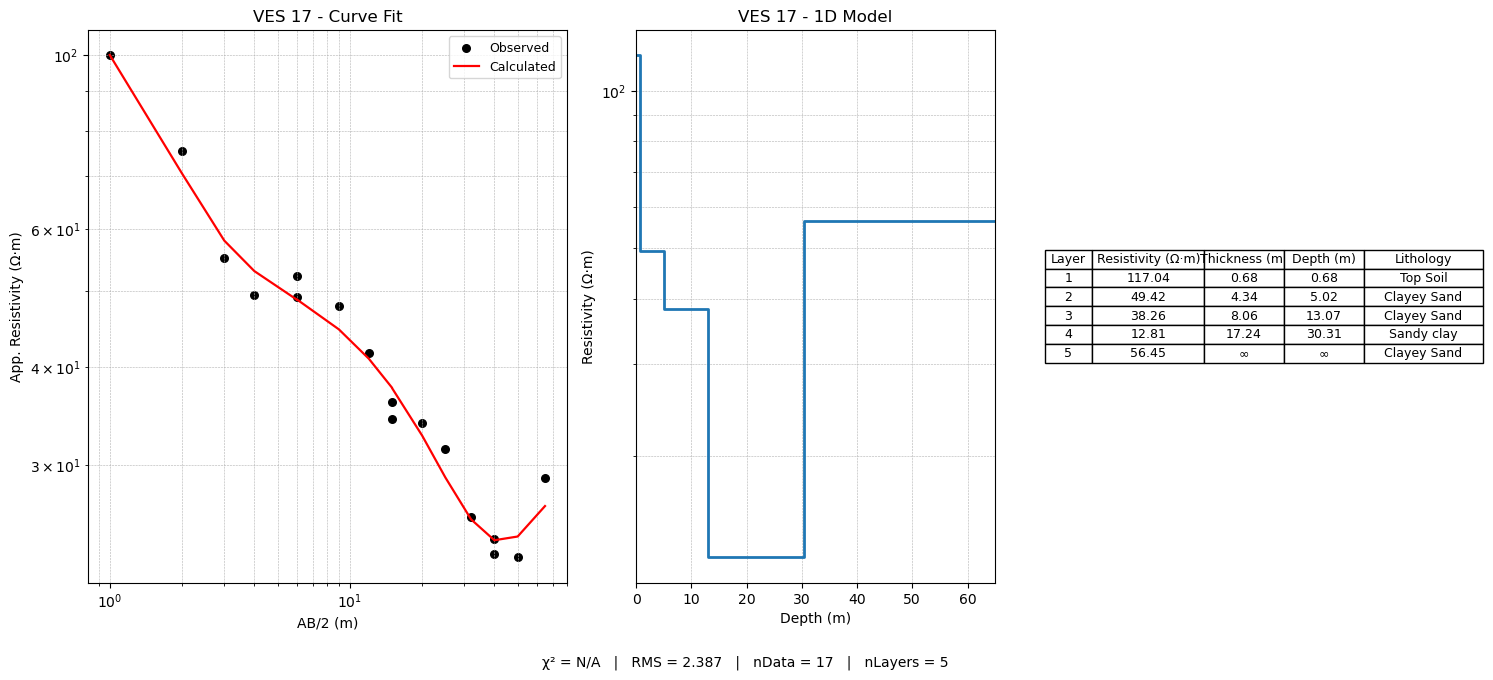

10/10/25 - 16:31:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:13 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


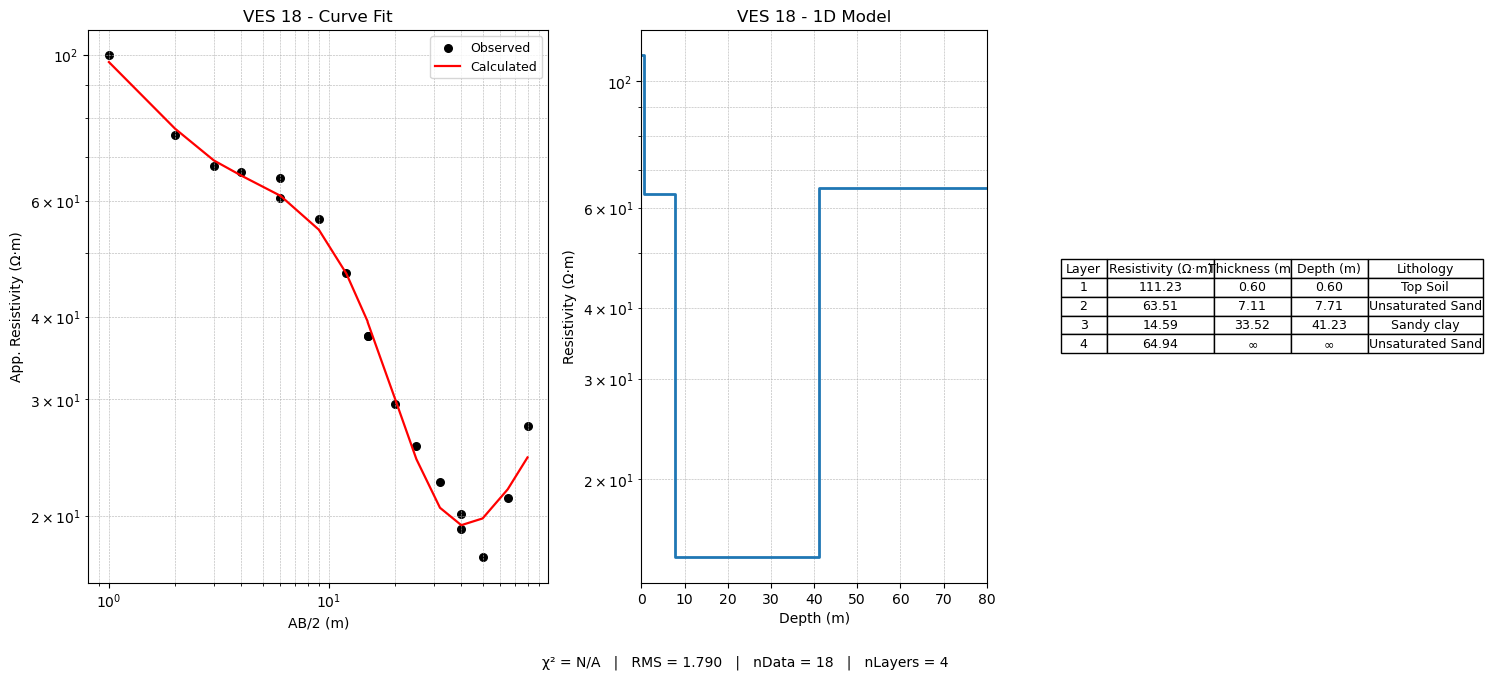

10/10/25 - 16:31:16 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:16 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:16 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:16 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:16 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


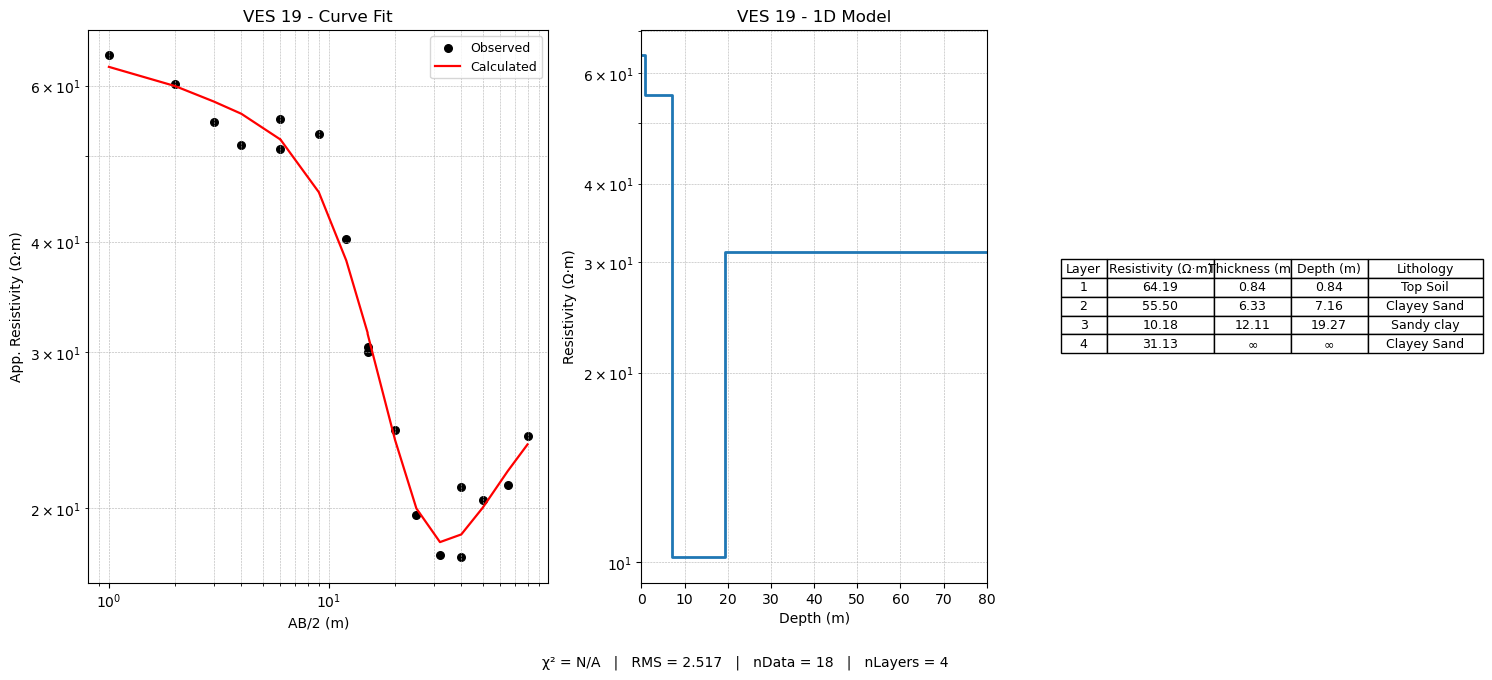

10/10/25 - 16:31:18 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:18 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:18 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:18 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:18 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:19 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:19 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
10/10/25 - 16:31:19 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


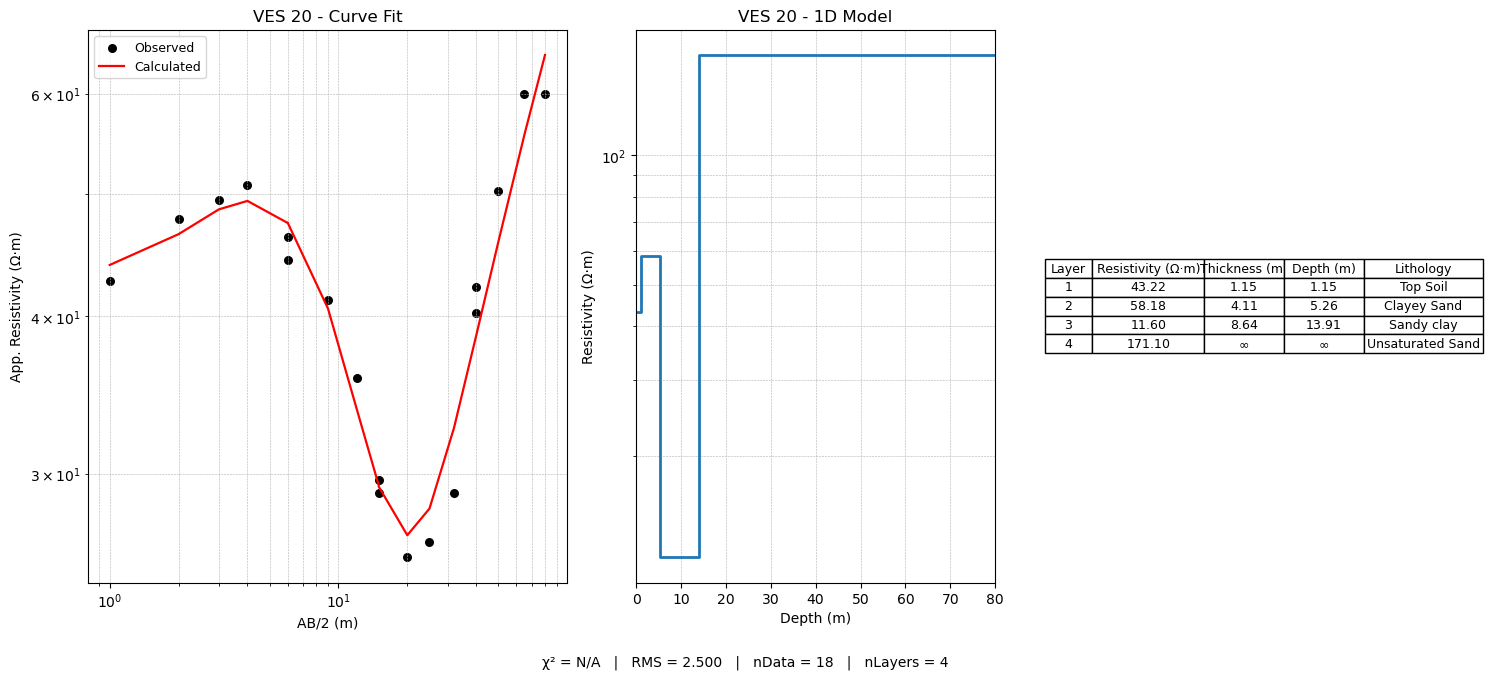

[DONE] Summary saved: C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output\summary.csv


In [14]:
"""
ves_reinv_pygimli_1.5.4  (fixed: no calls to fop.modelSize(); robust startModel sizing)

This is a drop-in replacement for your script. It forces agreement between the
start model size and the expected parameter vector size (2*nLayers - 1) and
handles 3, 4, 5 (and other) layer start models robustly.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import pygimli as pg
from pygimli.physics.ves import VESManager, VESModelling

# ---------------- CONFIG ----------------
MEASURED_XLSX = r"C:\Users\HOME\Desktop\ML Saline\VES\TR5.xlsx"
ROUGH_XLSX    = r"C:\Users\HOME\Desktop\ML Saline\VES\Pre Intrepreted depth and resistivity.xlsx"
OUT_DIR       = r"C:\Users\HOME\Desktop\ML Saline\VES\1D VES Output"

REL_ERR       = 0.03
DEPTH_FACTOR  = 1.5
LAMBDA        = 20
SHOW_PLOTS    = True

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- HELPERS ----------------

def classify_lithology(res):
    if res < 20:   return "Sandy clay"
    if res < 60:   return "Clayey Sand"
    if res < 600:  return "Unsaturated Sand"
    if res < 3000: return "Saturated Sand"
    return "Bedrock"


def fallback_thicknesses(n_layers, max_depth, ratio=2.0):
    """
    Return n_layers-1 thicknesses that approximately sum to max_depth.
    """
    if n_layers <= 1:
        return []
    n = n_layers - 1
    if n == 1:
        return [max_depth]
    denom = (ratio**n - 1) / (ratio - 1)
    t0 = max_depth / denom
    return (t0 * ratio**np.arange(n)).tolist()

def _find_col(df, keywords):
    cols = list(df.columns)
    for k in keywords:
        for c in cols:
            if k.lower() in c.lower():
                return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return nums[0] if len(nums) > 0 else None

# ---------------- IO: ROUGH MODELS ----------------

def load_rough_models(path):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] Rough-estimates file not found: {p}  -> proceeding without roughs")
        return {}

    sheets = pd.read_excel(p, sheet_name=None)
    dfs = []
    for sname, df in sheets.items():
        df2 = df.dropna(how="all").reset_index(drop=True)
        if df2.empty:
            continue
        df2['_sheet_name_'] = str(sname)
        dfs.append(df2)
    if not dfs:
        return {}
    big = pd.concat(dfs, ignore_index=True)

    ves_col = _find_col(big, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    res_col = _find_col(big, ['resist', 'res', 'rho'])
    thk_col = _find_col(big, ['thick', 'thk', 'thickness'])

    roughs = {}
    if ves_col is not None and ves_col not in ['_sheet_name_']:
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            res = pd.to_numeric(g[res_col], errors='coerce').dropna().tolist() if res_col else []
            thk = pd.to_numeric(g[thk_col], errors='coerce').dropna().tolist() if thk_col else []
            if res:
                roughs[str(key).strip()] = {'res': res, 'thk': thk}
    else:
        for sname, df in sheets.items():
            d = df.dropna(how='all').reset_index(drop=True)
            if d.empty: continue
            rcol = _find_col(d, ['resist','res','rho'])
            tcol = _find_col(d, ['thick','thk','thickness'])
            res = pd.to_numeric(d[rcol], errors='coerce').dropna().tolist() if rcol else []
            thk = pd.to_numeric(d[tcol], errors='coerce').dropna().tolist() if tcol else []
            if res:
                roughs[str(sname).strip()] = {'res': res, 'thk': thk}

    print(f"[INFO] Loaded rough models for {len(roughs)} VES soundings from {p.name}")
    return roughs

# ---------------- MEASURED DATA LOADER ----------------

def iterate_measured_workbook(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Measured workbook not found: {p}")

    sheets = pd.read_excel(p, sheet_name=None)
    first_df = next(iter(sheets.values())).dropna(how='all').reset_index(drop=True)
    ves_col = _find_col(first_df, ['ves', 'ves_no', 'vesid', 'ves id', 'ves no'])
    if ves_col is not None and ves_col in first_df.columns:
        dfs = [df.dropna(how='all').reset_index(drop=True) for df in sheets.values() if not df.dropna(how='all').empty]
        big = pd.concat(dfs, ignore_index=True)
        for key, g in big.groupby(big[ves_col].astype(str).str.strip()):
            yield str(key).strip(), g.reset_index(drop=True)
    else:
        for sname, df in sheets.items():
            yield str(sname).strip(), df.reset_index(drop=True)

# ---------------- INVERSION ----------------

def build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=None):
    """
    Ensure startModel is exactly the expected size. Expected size for nL layers
    is 2*nL - 1 (nL resistivities + nL-1 thicknesses).
    """
    target_thk_len = max(0, nL - 1)
    target_res_len = nL

    thk = list(map(float, thk0)) if thk0 is not None else []
    res = list(map(float, res0)) if res0 is not None else []

    if len(thk) < target_thk_len:
        more = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        thk = (thk + more)[:target_thk_len]

    if len(res) < target_res_len:
        last = res[-1] if len(res) > 0 else float(np.median(rhoa) if len(rhoa)>0 else 100.0)
        while len(res) < target_res_len:
            res.append(last)

    thk = thk[:target_thk_len]
    res = res[:target_res_len]

    start = np.array(list(thk) + list(res), dtype=float)

    # Do NOT rely on fop.modelSize(); compute expected size directly:
    expected_size = 2 * nL - 1
    # If fop provides a model-size-like attribute (rare), try to use it (safe guard)
    try:
        if fop is not None:
            if hasattr(fop, 'modelSize'):
                expected_size = int(fop.modelSize())
            elif hasattr(fop, 'size'):
                expected_size = int(fop.size())
    except Exception:
        expected_size = 2 * nL - 1

    # Adjust if mismatch
    if len(start) != expected_size:
        missing = expected_size - len(start)
        if missing > 0:
            # Prefer adding small thicknesses first, then resistivities
            while len(thk) < target_thk_len and len(start) < expected_size:
                thk.append(max(0.1, np.mean(thk) if len(thk)>0 else max(ab2)*0.05))
                start = np.array(list(thk) + list(res), dtype=float)
            while len(res) < target_res_len and len(start) < expected_size:
                res.append(res[-1] if len(res)>0 else (np.median(rhoa) if len(rhoa)>0 else 100.0))
                start = np.array(list(thk) + list(res), dtype=float)
        elif missing < 0:
            # truncate extras (prefer truncating extra thicknesses)
            thk = thk[:target_thk_len]
            res = res[:target_res_len]
            start = np.array(list(thk) + list(res), dtype=float)

    # final safety pad/truncate
    if len(start) != expected_size:
        if len(start) < expected_size:
            pad_val = np.median(rhoa) if len(rhoa)>0 else 100.0
            start = np.concatenate([start, np.full(expected_size - len(start), pad_val)])
        else:
            start = start[:expected_size]

    return start, thk, res

def invert_single(df, ab2_col, rhoa_col, name, roughs):
    df = df.dropna(how="all")
    if ab2_col not in df.columns or rhoa_col not in df.columns:
        return None

    df = df[(pd.to_numeric(df[ab2_col], errors='coerce')>0) & (pd.to_numeric(df[rhoa_col], errors='coerce')>0)].copy()
    if df.empty: return None

    df = df.sort_values(by=ab2_col)
    ab2 = df[ab2_col].astype(float).values
    rhoa = df[rhoa_col].astype(float).values
    mn2 = df.loc[:, df.columns.str.contains('mn2', case=False)].astype(float).values.flatten() if any(df.columns.str.contains('mn2', case=False)) else None

    rough = roughs.get(str(name).strip())
    if rough and len(rough.get('res', [])) >= 2:
        res0 = list(map(float, rough.get('res', [])))
        thk0 = list(map(float, rough.get('thk', [])))
        nL = len(res0)
        if nL < 2:
            nL = 2
        if len(thk0) < nL - 1:
            thk0 = thk0 + fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
            thk0 = thk0[:nL-1]
    else:
        nL = 4
        thk0 = fallback_thicknesses(nL, max(ab2)*DEPTH_FACTOR)
        median = np.median(rhoa) if len(rhoa)>0 else 100.0
        res0 = list(np.logspace(np.log10(max(1.0, median/3.0)), np.log10(median*3.0), nL))

    if nL < 2:
        nL = 2

    # Build a fop object for sizing check when possible (not required)
    try:
        fop_check = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
    except Exception:
        fop_check = None

    startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0, res0, ab2, rhoa, fop=fop_check)

    model = None
    used_manager = False
    try:
        fop = VESModelling(ab2=ab2, mn2=mn2, nLayers=nL)
        expected = 2 * nL - 1
        # final size guarantee
        if len(startModel) != expected:
            startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop)

        inv = pg.Inversion(fop=fop, verbose=False)
        model = inv.run(rhoa, lam=LAMBDA, startModel=startModel)
        used_manager = False
    except Exception as e:
        # fallback to VESManager wrapper
        try:
            vm = VESManager()
            model = vm.invert(rhoa, ab2=ab2, mn2=mn2, startModel=startModel, err=REL_ERR, showProgress=0)
            used_manager = True
        except Exception as e2:
            # last fallback: try VESModelling without nLayers
            try:
                fop2 = VESModelling(ab2=ab2, mn2=mn2)
                startModel, thk0_adj, res0_adj = build_and_adjust_startmodel(nL, thk0_adj, res0_adj, ab2, rhoa, fop=fop2)
                inv2 = pg.Inversion(fop=fop2, verbose=False)
                model = inv2.run(rhoa, lam=LAMBDA, startModel=startModel)
                used_manager = False
            except Exception as e3:
                print(f"[ERROR] Inversion failed for VES {name}. Exceptions:\n primary: {e}\n fallback1: {e2}\n fallback2: {e3}")
                return None

    model = np.asarray(model, dtype=float)

    # slice thicknesses and resistivities robustly
    if len(model) >= (nL - 1):
        thk_model = model[:max(0, nL-1)]
    else:
        thk_model = np.array([])

    if len(model) >= (len(thk_model) + nL):
        res_model = model[len(thk_model):len(thk_model)+nL]
    elif len(model) >= nL:
        res_model = model[-nL:]
    else:
        # fallback: try to consider last elements as resistivities
        res_model = model if len(model)>0 else np.array([np.median(rhoa) if len(rhoa)>0 else 100.0])

    # try compute forward response
    rho_calc = None
    try:
        if used_manager and 'vm' in locals() and hasattr(vm, 'fop') and vm.fop is not None:
            try:
                rho_calc = vm.fop.response(model)
            except Exception:
                rho_calc = None
        elif 'fop' in locals():
            try:
                rho_calc = fop.response(model)
            except Exception:
                rho_calc = None
    except Exception:
        rho_calc = None

    # depth tops
    depth_tops = np.concatenate([[0.0], np.cumsum(thk_model)]) if len(thk_model)>0 else np.array([0.0, max(ab2)])

    rows = []
    for i, r in enumerate(res_model):
        thick = float(thk_model[i]) if i < len(thk_model) else None
        depth = float(depth_tops[i+1]) if (i+1) < len(depth_tops) else (float(depth_tops[-1]) if len(depth_tops)>0 else None)
        lith = "Top Soil" if i == 0 else classify_lithology(float(r))
        rows.append({
            "layer": i+1,
            "resistivity_ohm_m": float(r),
            "thickness_m": thick,
            "depth_m": depth,
            "lithology": lith
        })

    chi2 = None; rms = None
    try:
        if used_manager and 'vm' in locals():
            if hasattr(vm, 'chi2'):
                try:
                    chi2 = vm.chi2(model)
                    rms = np.sqrt(chi2 / max(1, len(rhoa)))
                except Exception:
                    chi2 = None
            else:
                # compute residuals if possible
                if rho_calc is not None:
                    diff = (rhoa - rho_calc)
                    rms = np.sqrt(np.mean(diff**2))
                    chi2 = float('nan')
        else:
            if rho_calc is not None:
                diff = (rhoa - rho_calc)
                rms = np.sqrt(np.mean(diff**2))
                chi2 = float('nan')
    except Exception:
        pass

    return {
        "rows": rows,
        "ab2": ab2,
        "rhoa": rhoa,
        "rho_calc": rho_calc,
        "nLayers": len(res_model),
        "chi2": chi2,
        "rms": rms
    }

# ---------------- MAIN ----------------

def process(measured_xlsx, roughs_xlsx, out_dir):
    roughs = load_rough_models(roughs_xlsx) if roughs_xlsx else {}
    summary = []

    for ves_key, df in iterate_measured_workbook(measured_xlsx):
        ab2_col = _find_col(df, ['ab2','ab/2'])
        rhoa_col = _find_col(df, ['rho','rhoa','rho_a','app'])
        result = invert_single(df, ab2_col, rhoa_col, ves_key, roughs)
        if not result:
            print(f"[WARN] Skipping VES {ves_key} (inversion returned nothing).")
            continue

        out_folder = Path(out_dir) / str(ves_key)
        out_folder.mkdir(parents=True, exist_ok=True)

        df_layers = pd.DataFrame(result["rows"])
        df_layers.to_csv(out_folder / f"{ves_key}_layers.csv", index=False)

        # 3-panel plot
        fig, axes = plt.subplots(1, 3, figsize=(15,7), gridspec_kw={'width_ratios':[1.2,0.9,1]})

        # Panel 1: curve
        ax0 = axes[0]
        ax0.scatter(result["ab2"], result["rhoa"], c="k", s=30, label="Observed")
        if result["rho_calc"] is not None:
            ax0.plot(result["ab2"], result["rho_calc"], 'r-', linewidth=1.6, label="Calculated")
        ax0.set_xscale("log"); ax0.set_yscale("log")
        ax0.set_xlabel("AB/2 (m)"); ax0.set_ylabel("App. Resistivity (Ω·m)")
        ax0.set_title(f"VES {ves_key} - Curve Fit")
        ax0.legend(fontsize=9); ax0.grid(True, which="both", ls="--", lw=0.4)

        # Panel 2: depth (X) vs resistivity (Y)
        ax1 = axes[1]
        res_vals = [r['resistivity_ohm_m'] for r in result['rows']]
        thk_vals = [r['thickness_m'] for r in result['rows'] if r['thickness_m'] is not None]
        depth_tops = [0.0] + list(np.cumsum(thk_vals)) if thk_vals else [0.0]*(len(res_vals)+1)
        depths_plot = []
        rhos_plot = []
        for i, rv in enumerate(res_vals):
            top = depth_tops[i] if i < len(depth_tops) else 0.0
            bottom = depth_tops[i+1] if (i+1) < len(depth_tops) else max(result["ab2"])
            depths_plot.extend([top, bottom])
            rhos_plot.extend([rv, rv])
        if len(depths_plot) == 0:
            depths_plot = [0.0, max(result["ab2"])]
            rhos_plot = [res_vals[0] if res_vals else 100.0, res_vals[0] if res_vals else 100.0]
        ax1.semilogy(depths_plot, rhos_plot, linewidth=2)
        ax1.set_xlim(0, max(depths_plot))
        ax1.set_xlabel("Depth (m)")
        ax1.set_ylabel("Resistivity (Ω·m)")
        ax1.set_title(f"VES {ves_key} - 1D Model")
        ax1.grid(True, which="both", ls="--", lw=0.4)

        # Panel 3: table
        ax2 = axes[2]; ax2.axis('off')
        rows_table = [["Layer","Resistivity (Ω·m)","Thickness (m)","Depth (m)","Lithology"]]
        for i, r in enumerate(result['rows']):
            t = f"{r['thickness_m']:.2f}" if r['thickness_m'] is not None else "∞"
            # 👇 Force last row depth to ∞
            if i == len(result['rows']) - 1:
                d = "∞"
            else:
                d = f"{r['depth_m']:.2f}" if r['depth_m'] is not None else "∞"
            rows_table.append([r['layer'], f"{r['resistivity_ohm_m']:.2f}", t, d, r['lithology']])
        tbl = ax2.table(cellText=rows_table, cellLoc='center', loc='center', colWidths=[0.12,0.28,0.20,0.20,0.30])
        tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.1)

        # misfit annotation
        chi2 = result.get('chi2'); rms = result.get('rms')
        chi2_str = f"{chi2:.2f}" if chi2 is not None and not (isinstance(chi2,float) and np.isnan(chi2)) else "N/A"
        rms_str = f"{rms:.3f}" if rms is not None and not (isinstance(rms,float) and np.isnan(rms)) else "N/A"
        txt = f"χ² = {chi2_str}   |   RMS = {rms_str}   |   nData = {len(result['rhoa'])}   |   nLayers = {result['nLayers']}"
        fig.text(0.5, 0.01, txt, ha='center', fontsize=10)

        fig.tight_layout(rect=[0,0.04,1,0.97])
        fig.savefig(out_folder / f"{ves_key}_panel.png", dpi=200)
        if SHOW_PLOTS: plt.show()
        plt.close(fig)

        summary.append({"VES":ves_key,"nLayers":result["nLayers"],"chi2":result["chi2"],"rms":result["rms"],"out_folder":str(out_folder)})

    pd.DataFrame(summary).to_csv(Path(out_dir)/"summary.csv", index=False)
    print(f"[DONE] Summary saved: {Path(out_dir)/'summary.csv'}")

if __name__ == "__main__":
    process(MEASURED_XLSX, ROUGH_XLSX, OUT_DIR)


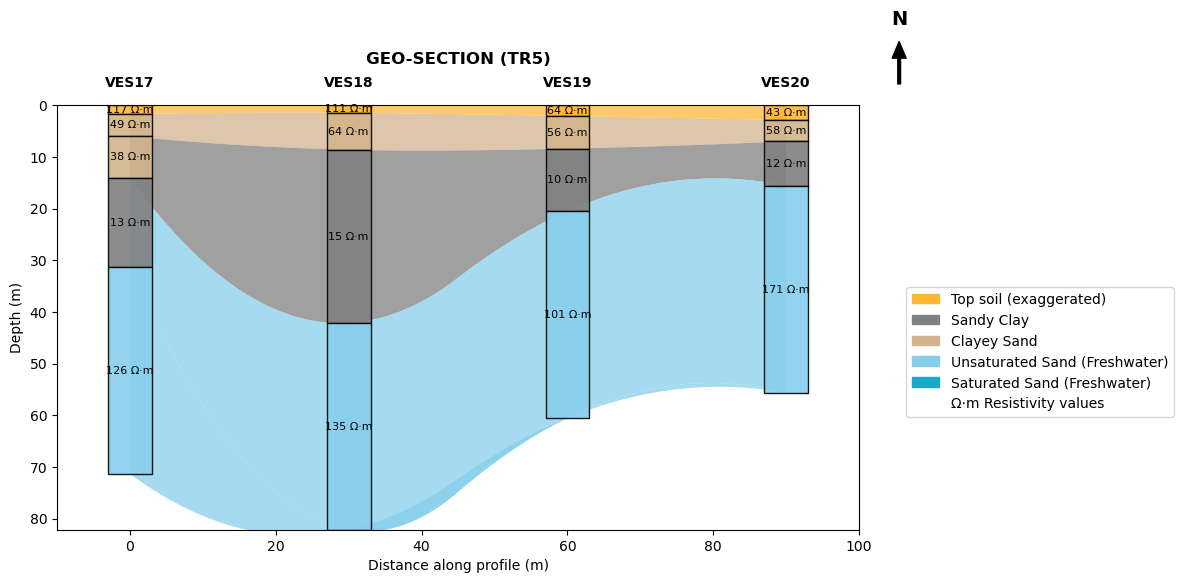

Figure saved at: C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS\GEO_SECTION_TR5.png


In [15]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
import matplotlib.patches as mpatches  
from scipy.interpolate import make_interp_spline  
import os  

# -------------------------------
# CONFIGURATION
# -------------------------------
excel_file = r"C:\Users\HOME\Desktop\ML Saline\VES\TR 5 Summary.xlsx"
ves_positions = {"VES17": 0, "VES18": 30, "VES19": 60, "VES20": 90}

profile_name = "TR5"
topsoil_exaggeration = 2.5  # exaggerate topsoil thickness ×1.5  

# -------------------------------  
# Lithology classification  
# -------------------------------  
def classify_lithology(rho, is_top=False):  
    if is_top:  
        return "Topsoil", "#FFB733", -1  # yellowish-orange  
    if rho < 20:  
        return "Sandy Clay", "grey", 0  
    elif 20 <= rho < 100:  
        return "Clayey Sand", "tan", 1  
    elif 60 <= rho < 500:  
        return "Unsaturatd Sand (Freshwater)", "skyblue", 2  
    elif rho >= 500:  
        return "Saturated Sand (Freshwater)", "#1CA9C9", 3   
    else:  
        return "Resitivity Value", "black", 4   

# -------------------------------  
# Read Excel file (multiple sheets)  
# -------------------------------  
ves_data = {}  
xls = pd.ExcelFile(excel_file)  

for sheet in xls.sheet_names:  
    df = pd.read_excel(excel_file, sheet_name=sheet)  
    res = pd.to_numeric(df["resistivity"], errors="coerce").tolist()  
    thk = pd.to_numeric(df["thickness"], errors="coerce").tolist()  

    # exaggerate topsoil thickness (only first layer)  
    if thk and not pd.isna(thk[0]):  
        thk[0] *= topsoil_exaggeration  

    key = sheet.replace(" ", "")  # normalize  
    ves_data[key] = {  
        "x": ves_positions[key],  
        "res": res,  
        "thk": [None if pd.isna(v) else v for v in thk]  
    }  

# -------------------------------  
# Step 1: Extract layer interfaces across all VES  
# -------------------------------  
layer_surfaces = []  
max_depth = 0  

for ves, data in ves_data.items():  
    depth = 0  
    surfaces = [0]  # start at ground surface  
    for h in data["thk"]:  
        h_val = h if h else 40  
        depth += h_val  
        surfaces.append(depth)  
    layer_surfaces.append(surfaces)  
    max_depth = max(max_depth, depth)  

# pad so all VES have same number of interfaces  
max_layers = max(len(s) for s in layer_surfaces)  
for s in layer_surfaces:  
    while len(s) < max_layers:  
        s.append(s[-1])  

layer_surfaces = list(map(list, zip(*layer_surfaces)))  # transpose  

# -------------------------------  
# Step 2: Smooth interpolate each interface  
# -------------------------------  
x_coords = list(ves_positions.values())  
xs_dense = np.linspace(min(x_coords), max(x_coords), 400)  

smooth_surfaces = []  
for surface in layer_surfaces:  
    spline = make_interp_spline(x_coords, surface, k=2)  
    smooth_surfaces.append(spline(xs_dense))  

# -------------------------------  
# Step 3: Average resistivities per layer (for colors)  
# -------------------------------  
layer_avg_rho = []  
for i in range(len(layer_surfaces) - 1):  
    vals = []  
    for ves, data in ves_data.items():  
        if i < len(data["res"]):  
            vals.append(data["res"][i])  
    layer_avg_rho.append(np.nanmean(vals) if vals else 50)  

# -------------------------------  
# Step 4: Plot smooth filled layers + VES bars  
# -------------------------------  
fig, ax = plt.subplots(figsize=(12, 6))  

for i in range(len(smooth_surfaces) - 1):  
    rho = layer_avg_rho[i]  
    is_top = (i == 0)  
    lith, color, _ = classify_lithology(rho, is_top=is_top)  

    ax.fill_between(xs_dense,  
                    smooth_surfaces[i],  
                    smooth_surfaces[i+1],  
                    color=color, edgecolor="none", alpha=0.75)  

# Overlay VES bars  
for ves, data in ves_data.items():  
    x = data["x"]  
    depth = 0  
    for i, rho in enumerate(data["res"]):  
        h = data["thk"][i] if data["thk"][i] else 40  
        bottom = depth + h  
        is_top = (i == 0)  
        lith, color, _ = classify_lithology(rho, is_top=is_top)  
        ax.fill_between([x-3, x+3], depth, bottom, color=color, edgecolor="k", alpha=0.9)  
        ax.text(x, (depth+bottom)/2, f"{rho:.0f} Ω·m", ha="center", va="center", fontsize=8)  
        depth = bottom  
    ax.text(x, -3, ves, ha="center", va="bottom", fontsize=10, fontweight="bold")  

# -------------------------------  
# Axis labels & title  
# -------------------------------  
ax.set_xlabel("Distance along profile (m)")  
ax.set_ylabel("Depth (m)")  
ax.set_title(f"GEO-SECTION ({profile_name})", pad=30, fontweight="bold")  

ax.set_ylim(max_depth, 0)  
ax.set_xlim(min(x_coords)-10, max(x_coords)+10)  

# Arrow pointing up with "N" at the top
ax.annotate('', 
            xy=(1.05, 1.15),  # arrow head (top)
            xytext=(1.05, 1.05),  # arrow tail (bottom)
            xycoords='axes fraction',
            arrowprops=dict(facecolor='black', width=2, headwidth=10))

# "N" label above the arrow
ax.text(1.05, 1.18, 'N', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=14, fontweight='bold')

# Legend (placed outside to the right, below the north arrow)
legend_patches = [
    mpatches.Patch(color="#FFB733", label="Top soil (exaggerated)"),
    mpatches.Patch(color="grey", label="Sandy Clay"),
    mpatches.Patch(color="tan", label="Clayey Sand"),
    mpatches.Patch(color="skyblue", label="Unsaturated Sand (Freshwater)"),
    mpatches.Patch(color="#1CA9C9", label="Saturated Sand (Freshwater)"),
    mpatches.Patch(facecolor="white", edgecolor="none", label="Ω·m Resistivity values")
]   
ax.legend(handles=legend_patches, loc="lower left",  
          bbox_to_anchor=(1.05, 0.25), frameon=True)  

plt.tight_layout()  


# -------------------------------
# SAVE FIGURE TO FOLDER
# -------------------------------
output_dir = r"C:\Users\HOME\Desktop\ML Saline\VES\2D GEO-SECTIONS"  # raw string for Windows path
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"GEO_SECTION_{profile_name}.png")

plt.savefig(output_path, dpi=300, bbox_inches="tight")  
plt.show()  

print(f"Figure saved at: {output_path}")  
